In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Hiragino Sans'
import seaborn as sns
pd.options.display.max_info_columns = 200
pd.set_option('display.max_columns', 50)
import numpy as np
import re
import os
import collections
import tqdm
from tqdm.notebook import trange
from func_timeout import func_timeout, FunctionTimedOut
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import warnings
warnings.simplefilter('ignore')
import gc
from datetime import datetime
from datetime import date

/Users/haradahiroto/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class PredictScr:
    def __init__(self):
        self.rank_list = ["新馬", "未勝利", "1勝", "500万", "2勝", "1000万", "3勝", "1600万", "OP", "オープン", "L", "G3", "G2", "G1", 
                          "１勝", "２勝", "３勝"]
        self.place_list = ["札幌", "函館", "福島", "新潟", "東京", "中山", "中京", "京都", "阪神", "小倉"]

    def search(self, search_url, places=[], hyde=False):
        if hyde:
            options = Options()
            options.add_argument('--headless')
            browser = webdriver.Chrome(options=options)
        else:
            browser = webdriver.Chrome()
        browser.get(search_url)
        browser.maximize_window()
        urls = []
        if not places:
            titles =  browser.find_elements(By.CLASS_NAME, "RaceList_DataTitle")
            length = len([title.text for title in titles if not not title.text])
            for i in range(length):
                lis = browser.find_elements(By.CSS_SELECTOR, "#RaceTopRace > div > dl:nth-child({}) > dd > ul > li".format(i+1))
                urls = urls + [li.find_element(By.CSS_SELECTOR, "a").get_attribute("href") for li in lis if ("新馬" not in li.find_element(By.CLASS_NAME, "ItemTitle").text)&("障害" not in li.find_element(By.CLASS_NAME, "ItemTitle").text)]
        else:
            for place in places:
                titles =  browser.find_elements(By.CLASS_NAME, "RaceList_DataTitle")
                titles = [title for title in titles if not not title.text]
                number = [place in title.text for title in titles].index(True) + 1
                lis = browser.find_elements(By.CSS_SELECTOR, "#RaceTopRace > div > dl:nth-child({}) > dd > ul > li".format(number))
                urls = urls + [li.find_element(By.CSS_SELECTOR, "a").get_attribute("href") for li in lis if ("新馬" not in li.find_element(By.CLASS_NAME, "ItemTitle").text)&("障害" not in li.find_element(By.CLASS_NAME, "ItemTitle").text)]
        urls = [url.replace("result", "shutuba") for url in urls]
        return urls

    def make_table(self, race_url):
        tab = pd.read_html(race_url)[0]
        tab.columns = [col[0] for col in tab.columns.to_list()]
        self.del_index = tab[tab["印"]=="取消"].index.tolist()
        tab = tab[tab["印"]!="取消"]
        self.odds_tab = tab[["Unnamed: 9_level_0", "人気"]]
        tab = tab.drop(["印", "Unnamed: 9_level_0", "人気", "お気に入り馬"], axis=1)
        tab = tab.rename(columns={"枠": "waku", "馬 番": "num", "馬名": "horse_name", "性齢": "sex_age",
                                  "斤量": "carry", "騎手": "jockey", "厩舎": "kyusya", "馬体重 (増減)": "weight(change)"})
        tab["head"] = len(tab)
        try:
            tab["weight"] = tab["weight(change)"].str.split("(").str.get(0)
            tab["weight_change"] = tab["weight(change)"].str.split("(").str.get(1).str.replace(")", "")
        except AttributeError:
            tab["weight"] = np.nan
            tab["weight_change"] = np.nan
        tab.loc[tab["weight_change"]=="前計不", "weight_change"] = np.nan
        tab["sex"] = tab["sex_age"].str[0]
        tab["age"] = tab["sex_age"].str[1]
        tab["horse_EW"] = tab["kyusya"].apply(self.to_region)
        html = requests.get(race_url)
        soup = BeautifulSoup(html.content, "html.parser")
        race_info = soup.find(class_="RaceData01").text.replace("\n", "").split("/")
        race_info2 = soup.find(class_="RaceData02").select("span")
        clock = race_info[0].split(":")[0] + re.search(r'\d+', race_info[0].split(":")[1]).group()
        try:
            rank_num = re.search(r'\d+', soup.find(class_="RaceName").select_one("span")["class"][1]).group()
        except TypeError:
            rank_num = 0
        rank_name = race_info2[4].text
        tab["race_rank"] = self.to_race_rank(rank_name, rank_num)
        tab["GD"] = re.search('[障芝ダ]', race_info[1]).group()
        tab["turn"] = re.search('[右左直]', race_info[1]).group()
        tab["dist"] = re.search(r'\d+', race_info[1]).group()
        try:
            tab["course"] = re.search('外', race_info[1]).group()
        except AttributeError:
            tab["course"] = "内"
        try:
            tab["weather"] = re.search('[晴曇小雨雪]', race_info[2]).group()
            tab["condition"] = re.search('[良稍重不]', race_info[3]).group()
        except IndexError:
            tab["weather"] = np.nan
            tab["condition"] = np.nan
        tab["year"] = datetime.now().year
        tab["month"] = datetime.now().month
        tab["day"] = datetime.now().day
        tab["kai"] = re.search(r'\d+', race_info2[0].text).group()
        tab["nichi"] = re.search(r'\d+', race_info2[2].text).group()
        tab["place"] = race_info2[1].text
        tab["prize"] = re.search(r'\d+', race_info2[-1].text).group()
        url_elements = soup.select("td.HorseInfo > div > div > span > a")
        self.horse_urls = [url_element.get("href") for i, url_element in enumerate(url_elements) if i not in self.del_index]
        tab["horse_url"] = self.horse_urls
        self.tab = tab
        self.horse_table()
        tab = pd.concat([self.tab, self.add_tab], axis=1)
        tab["race"] = tab["year"].astype(str) + tab["month"].astype(str) + tab["day"].astype(str) + clock
        tab = tab.drop(["sex_age", "kyusya", "weight(change)"], axis=1)
        int8_col = ["head", "age", "month", "day", "kai", "nichi"]
        int16_col = ["year", "dist"]
        tab[int8_col] = tab[int8_col].astype(float)
        tab[int16_col] = tab[int16_col].astype(float)
        return tab

    def horse_table(self):
        row_list = []
        self.no_sinba = True
        for url in self.horse_urls:
            h_tabs = pd.read_html(url)
            if len(h_tabs) < 4:
                row = [0, "y", "y", "y", "y"]
                row_list.append(row)
                self.no_sinba = False
            else:
                h_tab = h_tabs[3]
                if len(h_tab.columns) < 20:
                    h_tab = h_tabs[4]
                h_info = h_tabs[1]  
                use_tab = h_tab.iloc[:3]
                race_year, race_month, race_day = self.tab.loc[self.tab["horse_url"]==url, ["year", "month", "day"]].iloc[0]
                pre_year, pre_month, pre_day = use_tab.iloc[0,0].split("/")
                interval = self.day_interval(int(race_year)-int(pre_year), int(race_month)-int(pre_month), int(race_day)-int(pre_day))
                use_tab["year"] = use_tab["日付"].str.split("/").str.get(0)
                use_tab["month"] = use_tab["日付"].str.split("/").str.get(1)
                use_tab["day"] = use_tab["日付"].str.split("/").str.get(2)
                use_tab["place"] = use_tab["開催"].apply(self.to_place)
                use_tab["kai"] = use_tab["開催"].str[0]
                use_tab.loc[use_tab["kai"].str.isdigit()==False, "kai"] = "None"
                use_tab["nichi"] = use_tab["開催"].str[-1]
                use_tab.loc[use_tab["nichi"].str.isdigit()==False, "nichi"] = "None"
                use_tab["race_rank"] = use_tab["レース名"].apply(self.to_race_rank)
                race_jockey = self.tab.loc[self.tab["horse_url"]==url, "jockey"].iloc[0]
                use_tab["same_jockey"] = use_tab["騎手"].apply(lambda x: "y" if x == race_jockey else "n")
                use_tab["GD"] = use_tab["距離"].str[0]
                use_tab["dist"] = use_tab["距離"].str[1:]
                use_tab["not_central"] = use_tab["place"].apply(lambda x: "y" if x=="None" else "n")
                use_tab["is_overseas"] = use_tab["枠 番"].apply(lambda x: "y" if np.isnan(x) else "n")
                use_tab["time"] = use_tab["タイム"].apply(self.time_to_float)
                use_tab["4_corner"] = use_tab["通過"].fillna("None").str.split("-").str.get(-1)
                use_tab["first_3f"] = use_tab["ペース"].str.split("-").str.get(0)
                use_tab["last_3f"] = use_tab["ペース"].str.split("-").str.get(1)
                use_tab["weight"] = use_tab["馬体重"].str.split("(").str.get(0)
                try:
                    use_tab["weight_change"] = use_tab["馬体重"].str.split("(").str.get(1).str.replace(")", "")
                except AttributeError:
                    use_tab["weight_change"] = 0
                use_tab["prize"] = use_tab["賞金"].fillna(0)
                use_tab = use_tab.drop(["日付", "開催", "R", "映 像", "オ ッ ズ", "人 気", "騎手", "距離", 
                                        "馬場 指数", "タイム", "ﾀｲﾑ 指数", "ペース", "馬体重", "厩舎 ｺﾒﾝﾄ",
                                        "備考", "勝ち馬 (2着馬)", "賞金"], axis=1)
                row = np.ravel(use_tab.values).tolist()
                first_dist = "y" if not self.tab["dist"][0] in h_tab["距離"].str[1:].tolist() else "n"
                first_gd = "y" if not self.tab["GD"][0] in h_tab["距離"].str[0].tolist() else "n"
                first_place = "y" if not self.tab["place"][0] in h_tab["開催"].apply(self.to_place).tolist() else "n"
                first_jockey = "y" if not race_jockey in h_tab["騎手"].tolist() else "n"
                row = [interval, first_gd, first_dist, first_place, first_jockey] + row
                row_list.append(row)
        
        row_len_list = [len(row)==95 for row in row_list]
        if not any(row_len_list):
            row_list[0] = row_list[0] + ["None"]*(95-len(row_list[0]))
        base_columns = ["weather", "race_name", "head", "waku", "num", "result", "carry", "condition", "diff", "corner", "horse_last_3f",
                        "year", "month", "day", "place", "kai", "nichi", "race_rank", "same_jockey", "GD", "dist", "not_central",
                        "is_overseas", "time", "4_corner", "first_3f", "last_3f", "weight", "weight_change", "prize"]
        pre1_columns = ["pre1_" + x for x in base_columns]
        pre2_columns = ["pre2_" + x for x in base_columns]
        pre3_columns = ["pre3_" + x for x in base_columns]
        add_columns = ["interval", "first_gd", "first_dist", "first_place", "first_jockey"] + pre1_columns + pre2_columns + pre3_columns
        self.add_tab = pd.DataFrame(row_list, columns=add_columns)

    def use_selenium(self, race_url, horse_urls, del_index):
        self.browser.get(race_url)
        odds_elements = self.browser.find_elements(By.CSS_SELECTOR, "td.Txt_R.Popular")
        oddss = [odd_element.text for i, odd_element in enumerate(odds_elements) if i not in del_index]
        pop_elements = self.browser.find_elements(By.CSS_SELECTOR, "td.Popular.Popular_Ninki.Txt_C")
        pops = [pop_element.text for i, pop_element in enumerate(pop_elements) if i not in del_index]
        row_list = []
        for horse_url in horse_urls:
            self.browser.get(horse_url)
            pre_time_tds = self.browser.find_elements(By.CSS_SELECTOR, "td:nth-child(20)")
            if not pre_time_tds:
                row_list.append(["None"])
            else:
                pre_times =[td.text for td in pre_time_tds]
                pre_times = pre_times[:3]
                pre_cond_tds = self.browser.find_elements(By.CSS_SELECTOR, "td:nth-child(17)")
                pre_conds = [td.text for td in pre_cond_tds]
                pre_conds = pre_conds[:3]
                row = ["None"]*(len(pre_conds)+len(pre_times))
                row[::2] = pre_conds
                row[1::2] = pre_times
                row_list.append(row)
        row_len_list = [len(row)==6 for row in row_list]
        if not any(row_len_list):
            row_list[0] = row_list[0] + ["None"]*(6-len(row_list[0]))
        selenium_tab = pd.DataFrame(row_list, columns=["pre1_relative_cond", "pre1_relative_time", "pre2_relative_cond",
                                                       "pre2_relative_time", "pre3_relative_cond", "pre3_relative_time"])
        selenium_tab["odds"] = oddss
        selenium_tab["popular"] = pops
        return selenium_tab
        
    def make_df(self, race_url_list, hyde=False):
        tab_list = []
        horse_urls_list = []
        del_index_list = []
        pass_list = []
        for i in tqdm.tqdm(range(len(race_url_list))):
            tab = self.make_table(race_url_list[i])
            if self.no_sinba:
                tab_list.append(tab)
                horse_urls_list.append(self.horse_urls)
                del_index_list.append(self.del_index)
            else:
                pass_list.append(i)
        selenium_tab_list = []
        if hyde:
            options = Options()
            options.add_argument('--headless')
            self.browser = webdriver.Chrome(options=options)
        else:
            self.browser = webdriver.Chrome()
        self.browser.get("https://regist.netkeiba.com/account/?pid=login")
        login_id = "hiroto.h.14@icloud.com"
        password = "mutumison14"
        self.browser.find_element(By.NAME, "login_id").send_keys(login_id)
        self.browser.find_element(By.NAME, "pswd").send_keys(password)
        self.browser.find_element(By.CSS_SELECTOR, "div > form > div > div.loginBtn__wrap > input[type=image]").click()
        selenium_race_url_list = [race_url for i, race_url in enumerate(race_url_list) if i not in pass_list]
        for i in tqdm.tqdm(range(len(selenium_race_url_list))):
            selenium_tab = self.use_selenium(selenium_race_url_list[i], horse_urls_list[i], del_index_list[i])
            selenium_tab_list.append(selenium_tab)
        race_df = pd.concat(tab_list, ignore_index=True)
        add_df = pd.concat(selenium_tab_list, ignore_index=True)
        df = pd.concat([race_df, add_df], axis=1)
        for index in pass_list:
            print(f'新馬を含むため消したレース: {race_url_list[index]}')
        return df
        
    def make_csv(self, df, name):
        df.to_csv("/Users/haradahiroto/machine_learning/z_keiba/predict_folder/"+name+".csv")
        
    def to_region(self, kyusya):
        if "栗東" in kyusya:
            ew = "西"
        elif "美浦" in kyusya:
            ew = "東"
        elif "地方" in kyusya:
            ew = "地"
        elif "海外" in kyusya:
            ew = "外"
        else:
            ew = "unknown"
        return ew
        
    def to_race_rank(self, rank_name, rank_num="None"):
        ranks = []
        if rank_num == "1":
            ranks.append("G1")
        if rank_num == "2":
            ranks.append("G2")
        if rank_num == "3":
            ranks.append("G3")
        if rank_num == "5":
            ranks.append("オープン")
        if rank_num == "15":
            ranks.append("L")
        if not ranks:
            for i in self.rank_list:
                if i in rank_name:
                    ranks.append(i)
        if not ranks:
            ranks.append("None")
        if (ranks[0]=="500万")|(ranks[0]=="１勝"):
            ranks[0]="1勝"
        if (ranks[0]=="1000万")|(ranks[0]=="２勝"):
            ranks[0]="2勝"
        if (ranks[0]=="1600万")|(ranks[0]=="３勝"):
            ranks[0]="3勝"
        return ranks[0]
        
    def to_place(self, info):
        places = []
        for i in self.place_list:
            if i in info:
                places.append(i)
        if not places:
            places.append("None")
        return places[0]
        
    def time_to_float(self, time):
        try:
            m,s = time.split(":")
        except AttributeError:
            m = 0
            s = 0
        return float(m)*60 + float(s)
        
    def day_interval(self,a,b,c):
        return (b+(a*12))*30+c


In [33]:
class MakeCSV:
    def __init__(self):
        self.rank_list = ["新馬", "未勝利", "1勝", "500万", "2勝", "1000万", "3勝", "1600万", "OP", "オープン", "L", "G3", "G2", "G1"]
        self.place_list = ["札幌", "函館", "福島", "新潟", "東京", "中山", "中京", "京都", "阪神", "小倉"]
        
    def search(self, place, s_year, f_year, s_month=1, f_month=12, rank="all", gd="grass", dist="all", age="all", fem=False, race_name="None", hyde=False):
        search_place = place
        place_dict = {"札幌":"check_Jyo_01", "函館":"check_Jyo_02", "福島":"check_Jyo_03", "新潟":"check_Jyo_04",
                      "東京":"check_Jyo_05", "中山":"check_Jyo_06", "中京":"check_Jyo_07", "京都":"check_Jyo_08",
                      "阪神":"check_Jyo_09", "小倉":"check_Jyo_10"}
        rank_dict = {"G1": 1, "G2": 2, "G3": 3, "OP": 4, "3勝":5, "2勝":6, "1勝":7, "新馬":8, "未勝利":9}
        age_dict = {"2歳": 11, "3歳": 12, "3歳以上": 13, "4歳以上": 14}
        for word, read in place_dict.items():
            search_place = search_place.replace(word, read)
        
        if hyde:
            options = Options()
            options.add_argument('--headless')
            browser = webdriver.Chrome(options=options)
        else:
            browser = webdriver.Chrome()
        browser.get("https://db.netkeiba.com/?pid=race_search_detail")
        browser.maximize_window()
        
        browser.find_element(By.ID, search_place).click()

        if rank=="all":
             rank_range = [1, 2, 3, 4, 5, 6, 7, 9]
        else:
            rank_range = [rank_dict[r] for r in rank]
        for num in rank_range:
            browser.find_element(By.ID, "check_grade_{}".format(num)).click()
        
        browser.find_element(By.ID, "check_track_1").click()
        if gd == "mix":
            browser.find_element(By.ID, "check_track_2").click()
        elif gd == "only_dirt":
            browser.find_element(By.ID, "check_track_1").click()
            browser.find_element(By.ID, "check_track_2").click()
        
        if dist != "all":
            for d in dist:
                browser.find_element(By.ID, "check_kyori_{}".format(str(d))).click()
        
        if age == "all":
            age_range = [11, 12, 13, 14]
        else:
            age_range = [age_dict[a] for a in age]
        for num in age_range:
            browser.find_element(By.ID, "check_barei_{}".format(num)).click()

        if fem:
            browser.find_element(By.ID, "check_jyoken_1").click()

        if race_name!="None":
            browser.find_element(By.CSS_SELECTOR, "form > table > tbody > tr:nth-child(1) > td > input").send_keys(race_name)
        
        css_form = "form > table > tbody > tr:nth-child(3) > td > select:nth-child({}) > option:nth-child({})"
        this_year = int(browser.find_element(By.CSS_SELECTOR, css_form.format(1,2)).text)
        s_year_css = str(2 + (this_year - s_year))
        s_month_css = str(1 + s_month)
        f_year_css = str(2 + (this_year - f_year))
        f_month_css = str(1 + f_month)
        browser.find_element(By.CSS_SELECTOR, css_form.format("1", s_year_css)).click()
        browser.find_element(By.CSS_SELECTOR, css_form.format("2", s_month_css)).click()
        browser.find_element(By.CSS_SELECTOR, css_form.format("3", f_year_css)).click()
        browser.find_element(By.CSS_SELECTOR, css_form.format("4", f_month_css)).click()
        
        browser.execute_script("window.scrollTo(0, 600);")
        browser.find_element(By.CSS_SELECTOR, "form > table > tbody > tr:nth-child(11) > td > select > option:nth-child(3)").click()
        browser.find_element(By.XPATH, "//input[@value='検索']").click()  
        
        url_elements = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(5) > a")
        self.race_urls = [element.get_attribute("href") for element in url_elements]
        if len(browser.find_elements(By.CSS_SELECTOR, "li")) > 80:
            browser.execute_script("window.scrollTo(0, 2500);")
            browser.find_element(By.CSS_SELECTOR, "div.common_pager > ul:nth-child(2) > li:nth-child(5) > a").click()
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            browser.execute_script("window.scrollBy(0, -1000);")
            page_num = int(browser.find_element(By.CSS_SELECTOR, "div.common_pager > ul:nth-child(1) > li.Page_Active").text)
            browser.find_element(By.CSS_SELECTOR, "div.common_pager > ul:nth-child(2) > li:nth-child(3) > a").click()
            css_next_form = "div.common_pager > ul:nth-child(1) > li:nth-child({}) > a"
            for i in range(page_num-1):
                if page_num < 10:
                    browser.execute_script("window.scrollTo(0, 2500);")
                    browser.find_element(By.CSS_SELECTOR, css_next_form.format(str(page_num+4))).click()
                else:
                    browser.execute_script("window.scrollTo(0, 2500);")
                    browser.find_element(By.CSS_SELECTOR, css_next_form.format(str(14))).click()
                url_elements = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(5) > a")
                urls = [element.get_attribute("href") for element in url_elements]
                self.race_urls = self.race_urls + urls
        self.race_nums = len(self.race_urls)
        print("レース数:", self.race_nums)
        return self.race_urls
    
    def make_table(self, race_url, no_odds=True):
        self.race_url = race_url
        tables = pd.read_html(self.race_url)
        self.tab = tables[0]
        while not str(self.tab.iloc[-1,0]).isdigit():
            self.tab = self.tab.drop(self.tab.index[-1])
        self.head = len(self.tab)
        self.tab["head"] = self.head
        self.tab["horse_EW"] = self.tab["調教師"].str[1]
        self.tab["weight"] = self.tab["馬体重"].str.split("(").str.get(0)
        self.tab["weight_change"] = self.tab["馬体重"].str.split("(").str.get(1).str.replace(")", "")
        self.tab["sex"] = self.tab["性齢"].str[0]
        self.tab["age"] = self.tab["性齢"].str[1:]
        self.tab = self.tab.drop(["着差", "性齢", "馬体重", "調教師"], axis=1)
        if no_odds:
            self.tab = self.tab.drop(["単勝", "人 気"], axis=1)
        self.use_bs()
        self.horse_url()
        self.horse_table()
        #self.use_selenium()  make_tableに入れるとしたらここ
        self.tab = pd.concat([self.tab, self.add_tab], axis=1)
        self.tab = self.tab.rename(columns={"着 順":"result", "枠 番":"waku", "馬 番":"num", "斤量":"carry", "単勝":"odds",
                                            "人 気":"popular"})
        self.tab["race"] = self.tab["year"] + self.tab["month"] + self.tab["day"] + self.clock
        self.tab["class"] = 0
        div = np.round((self.head-3)/2)+3
        self.tab.loc[3:div, "class"] = 1
        self.tab.loc[div:, "class"] = 2
        self.tab["reg"] = self.tab["タイム"].apply(self.time_to_float)
        #self.tab["relative_time"] = self.relative_times
        #self.tab = self.tab.drop(["馬名", "騎手", "タイム", "horse_url"], axis=1)
        self.tab = self.tab.drop(["タイム"], axis=1)
        self.tab = self.tab.rename(columns={"馬名": "horse_name", "騎手": "jockey"})
        int8_col = ["waku", "num", "head", "weight_change", "age", "month", "day", "kai", "nichi", "class"]
        int16_col = ["year", "weight", "dist"]
        self.tab[int8_col] = self.tab[int8_col].astype("int8")
        self.tab[int16_col] = self.tab[int16_col].astype("int16")
        return self.tab
        
    def use_bs(self):
        html = self.get_html(self.race_url)
        soup = BeautifulSoup(html.content, "html.parser")
        title_soup = soup.find(class_="data_intro")
        self.table_soup = soup.select_one("table")
        race_info = title_soup.select_one("span").text.replace("\xa0", "").split("/")
        race_info2 = title_soup.find(class_="smalltxt").text.replace("\xa0", "").split(" ")
        race_name = title_soup.select_one("h1").text
        race_div = race_info2[2]
        self.tab["race_rank"] = self.to_race_rank(race_name, race_div)
        self.tab["GD"] = re.search('[障芝ダ]', race_info[0]).group()
        self.tab["turn"] = re.search('[右左直]', race_info[0]).group()
        self.tab["dist"] = re.search(r'\d+', race_info[0]).group()
        try:
            self.tab["course"] = re.search('外', race_info[0]).group()
        except AttributeError:
            self.tab["course"] = "内"
        self.tab["weather"] = re.search('[晴曇小雨雪]', race_info[1]).group()
        clock = race_info[3].split(":")
        self.clock = clock[1].strip() + clock[2].strip()
        self.tab["condition"] = re.search('[良稍重不]', race_info[2]).group()
        self.tab["year"] = re.findall(r'\d+', race_info2[0])[0]
        self.tab["month"] = re.findall(r'\d+', race_info2[0])[1]
        self.tab["day"] = re.findall(r'\d+', race_info2[0])[2]
        self.tab["kai"] = re.findall(r'\d+', race_info2[1])[0]
        self.tab["nichi"] = re.findall(r'\d+', race_info2[1])[1]
        self.tab["place"] = self.to_place(race_info2[1])
        self.tab["prize"] = self.table_soup.select("tr")[1].select("td")[-1].text
        
    def horse_url(self):
        self.url_list = []
        tr_list = self.table_soup.select("tr")[1:self.head+1]
        for tr in tr_list:
            href = tr.select("td")[3].find("a").get("href")
            url = "https://db.netkeiba.com" + href
            self.url_list.append(url)
        self.tab["horse_url"] = self.url_list
    
    def horse_table(self):
        row_list = []
        self.ind_list = []
        for url in self.url_list:
            h_tabs = pd.read_html(url)
            h_tab = h_tabs[3]
            if len(h_tab.columns) < 20:
                h_tab = h_tabs[4]
            h_info = h_tabs[1]
            #all_prize = h_info.set_index(0).loc["獲得賞金", 1].split("万")[0].replace(",", "").replace("億", "")
            
            race_year, race_month, race_day = self.tab.loc[self.tab["horse_url"]==url, ["year", "month", "day"]].iloc[0]
            race_date = race_year+"/"+race_month.zfill(2)+"/"+race_day.zfill(2)
            ind = h_tab[h_tab["日付"]==race_date].index[0]
            self.ind_list.append(ind)
            use_tab = h_tab.iloc[ind+1:ind+4]
            if use_tab.empty:
                row = [0, "y", "y", "y", "y"]
                row_list.append(row)
            else:
                pre_year, pre_month, pre_day = use_tab.iloc[0,0].split("/")
                interval = self.day_interval(int(race_year)-int(pre_year), int(race_month)-int(pre_month), int(race_day)-int(pre_day))
                use_tab["year"] = use_tab["日付"].str.split("/").str.get(0)
                use_tab["month"] = use_tab["日付"].str.split("/").str.get(1)
                use_tab["day"] = use_tab["日付"].str.split("/").str.get(2)
                use_tab["place"] = use_tab["開催"].apply(self.to_place)
                use_tab["kai"] = use_tab["開催"].str[0]
                use_tab.loc[use_tab["kai"].str.isdigit()==False, "kai"] = "None"
                use_tab["nichi"] = use_tab["開催"].str[-1]
                use_tab.loc[use_tab["nichi"].str.isdigit()==False, "nichi"] = "None"
                use_tab["race_rank"] = use_tab["レース名"].apply(self.to_race_rank)
                race_jockey = self.tab.loc[self.tab["horse_url"]==url, "騎手"].iloc[0]
                use_tab["same_jockey"] = use_tab["騎手"].apply(lambda x: "y" if x == race_jockey else "n")
                use_tab["GD"] = use_tab["距離"].str[0]
                use_tab["dist"] = use_tab["距離"].str[1:]
                use_tab["not_central"] = use_tab["place"].apply(lambda x: "y" if x=="None" else "n")
                use_tab["is_overseas"] = use_tab["枠 番"].apply(lambda x: "y" if np.isnan(x) else "n")
                use_tab["time"] = use_tab["タイム"].apply(self.time_to_float)
                use_tab["4_corner"] = use_tab["通過"].fillna("None").str.split("-").str.get(-1)
                use_tab["first_3f"] = use_tab["ペース"].str.split("-").str.get(0)
                use_tab["last_3f"] = use_tab["ペース"].str.split("-").str.get(1)
                use_tab["weight"] = use_tab["馬体重"].str.split("(").str.get(0)
                try:
                    use_tab["weight_change"] = use_tab["馬体重"].str.split("(").str.get(1).str.replace(")", "")
                except AttributeError:
                    use_tab["weight_change"] = 0
                use_tab["prize"] = use_tab["賞金"].fillna(0)
                use_tab = use_tab.drop(["日付", "開催", "R", "映 像", "オ ッ ズ", "人 気", "騎手", "距離", 
                                    "馬場 指数", "タイム", "ﾀｲﾑ 指数", "ペース", "馬体重", "厩舎 ｺﾒﾝﾄ",
                                    "備考", "勝ち馬 (2着馬)", "賞金"], axis=1)
                row = np.ravel(use_tab.values).tolist()
                pre_tab = h_tab[ind+1:]
                first_dist = "y" if not self.tab["dist"][0] in pre_tab["距離"].str[1:].tolist() else "n"
                first_gd = "y" if not self.tab["GD"][0] in pre_tab["距離"].str[0].tolist() else "n"
                first_place = "y" if not self.tab["place"][0] in pre_tab["開催"].apply(self.to_place).tolist() else "n"
                first_jockey = "y" if not race_jockey in pre_tab["騎手"].tolist() else "n"
                row = [interval, first_gd, first_dist, first_place, first_jockey] + row
                row_list.append(row)
        
        row_len_list = [len(row)==95 for row in row_list]
        if not any(row_len_list):
            row_list[0] = row_list[0] + ["None"]*(95-len(row_list[0]))
        base_columns = ["weather", "race_name", "head", "waku", "num", "result", "carry", "condition", "diff", "corner", "horse_last_3f",
                        "year", "month", "day", "place", "kai", "nichi", "race_rank", "same_jockey", "GD", "dist", "not_central",
                        "is_overseas", "time", "4_corner", "first_3f", "last_3f", "weight", "weight_change", "prize"]
        pre1_columns = ["pre1_" + x for x in base_columns]
        pre2_columns = ["pre2_" + x for x in base_columns]
        pre3_columns = ["pre3_" + x for x in base_columns]
        add_columns = ["interval", "first_gd", "first_dist", "first_place", "first_jockey"] + pre1_columns + pre2_columns + pre3_columns
        self.add_tab = pd.DataFrame(row_list, columns=add_columns)
    
    def use_selenium(self, race_url, horse_url_list, ind_list):
        self.browser.get(race_url)
        time_tds = self.browser.find_elements(By.CSS_SELECTOR, "td:nth-child(10)")
        relative_times = [td.text for td in time_tds]
        if len(relative_times) > len(horse_url_list):
            relative_times = relative_times[:len(horse_url_list)]
        relative_cond = self.browser.find_element(By.CSS_SELECTOR, "table.result_table_02 td").text.split("(")[0]
        row_list = []
        for horse_url, ind in zip(horse_url_list, ind_list):
            self.browser.get(horse_url)
            pre_time_tds = self.browser.find_elements(By.CSS_SELECTOR, "td:nth-child(20)")
            pre_times =[td.text for td in pre_time_tds]
            pre_times = pre_times[ind+1:ind+4]
            if not pre_times:
                row_list.append(["None"])
            else:
                pre_cond_tds = self.browser.find_elements(By.CSS_SELECTOR, "td:nth-child(17)")
                pre_conds = [td.text for td in pre_cond_tds]
                pre_conds = pre_conds[ind+1:ind+4]
                row = ["None"]*(len(pre_conds)+len(pre_times))
                row[::2] = pre_conds
                row[1::2] = pre_times
                row_list.append(row)
        row_len_list = [len(row)==6 for row in row_list]
        if not any(row_len_list):
            row_list[0] = row_list[0] + ["None"]*(6-len(row_list[0]))
        selenium_tab = pd.DataFrame(row_list, columns=["pre1_relative_cond", "pre1_relative_time", "pre2_relative_cond",
                                                       "pre2_relative_time", "pre3_relative_cond", "pre3_relative_time"])
        selenium_tab["relative_cond"] = relative_cond
        selenium_tab["relative_time"] = relative_times
        return selenium_tab
            
    def make_df(self, race_url_list, hyde=False, no_odds=True):
        self.tab_list = []
        self.rr_list = []
        self.gd_list = []
        self.dist_list = []
        self.horse_url_list_list = []
        self.ind_list_list = []
        self.pass_list = []
        self.add_pass_list = []
        for i in tqdm.tqdm(range(len(race_url_list))):
            try:
                tab = self.make_table(race_url_list[i], no_odds=no_odds)
            except (AttributeError, TypeError, KeyError, ImportError, ValueError):
                self.pass_list.append(i)
            else:
                self.tab_list.append(tab)
                race_rank = tab["race_rank"].iloc[0]
                self.rr_list.append(race_rank)
                gd = tab["GD"].iloc[0]
                self.gd_list.append(gd)
                dist = tab["dist"].iloc[0]
                self.dist_list.append(dist)
                self.horse_url_list_list.append(self.url_list)
                self.ind_list_list.append(self.ind_list)
        self.selenium_tab_list = []
        if hyde:
            options = Options()
            options.add_argument('--headless')
            self.browser = webdriver.Chrome(options=options)
        else:
            self.browser = webdriver.Chrome()
        self.browser.get("https://regist.netkeiba.com/account/?pid=login")
        login_id = "hiroto.h.14@icloud.com"
        password = "mutumison14"
        self.browser.find_element(By.NAME, "login_id").send_keys(login_id)
        self.browser.find_element(By.NAME, "pswd").send_keys(password)
        self.browser.find_element(By.CSS_SELECTOR, "div > form > div > div.loginBtn__wrap > input[type=image]").click()
        for i in tqdm.tqdm(range(len(race_url_list))):
            if not i in self.pass_list:
                try:
                    selenium_tab = self.use_selenium(race_url_list[i], self.horse_url_list_list[i], self.ind_list_list[i])
                except (AttributeError, TypeError, KeyError, ImportError, ValueError):
                    self.add_pass_list.append(i)
                else:
                    self.selenium_tab_list.append(selenium_tab)
        for i in self.add_pass_list:
            self.tab_list.remove(self.tab_list[i])
            self.rr_list.remove(self.rr_list[i])
            self.gd_list.remove(self.gd_list[i])
            self.dist_list.remove(self.dist_list[i])
        self.df = pd.concat(self.tab_list, ignore_index=True)
        self.add_df = pd.concat(self.selenium_tab_list, ignore_index=True)
        self.df = pd.concat([self.df, self.add_df], axis=1)
        print("number of race:", len(self.tab_list))
        print("race_rank:", collections.Counter(self.rr_list))
        print("gd:", collections.Counter(self.gd_list))
        print("dist:", collections.Counter(self.dist_list))
        return self.df

    def df_race_url(self, df, race_urls): #race_urlsとdfのレース数が同じで共に新しい順に並んでいるとする
        df["race_url"] = 0
        for i, code in enumerate(df.race.unique().tolist()):
            df.loc[df.race==code, "race_url"] = race_urls[i]
        return df

    def lap_scr(self, race_url):
        tab = pd.read_html(race_url)[5]
        laps = tab.loc[tab[0]=="ラップ", 1][0].split("-")
        laps = [float(l.strip()) for l in laps]
        paces = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[0].split("-")
        tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
        paces = [float(p.strip()) for p in paces]
        ten = float(tl.split("-")[0].replace("(", ""))
        last = float(tl.split("-")[1].replace(")", ""))
        browser = webdriver.Chrome()
        browser.get(race_url)
        ag_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(12)")
        agaris = [float(td.text) for td in ag_tds]
        kati_ag = agaris[0]
        saisoku_ag = sorted(agaris)[0]
        dict = {"lap": laps, "paces": paces, "ten_3f": ten, "last_3f": last,
                "winning": kati_ag, "fastest": saisoku_ag}
        return dict

    def lap_scr_df(self, df, url_col="race_url", rest_100=False):
        browser = webdriver.Chrome()
        df["lap"] = 0
        df["race_ten3f"] = 0
        df["race_last3f"] = 0
        df["race_mids"] = 0
        df["horse_last3f"] = 0
        df["horse_mids"] = 0
        df["position"] = 0
        df["last_corner"] = 0
        df["avg_last3f"] = 0
        df["avg_mid"] = 0
        for race_url in df[url_col].unique().tolist():
            tab = pd.read_html(race_url)[5]
            df.loc[df[url_col]==race_url, "lap"] = tab.loc[tab[0]=="ラップ", 1][0]
            tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
            ten = float(tl.split("-")[0].replace("(", ""))
            last = float(tl.split("-")[1].replace(")", ""))
            browser.get(race_url)
            #contents_liquid > table > tbody > tr.txt_c.even > th:nth-child(1)
            r_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(1)")
            rs = [td.text for td in r_tds]
            ag_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(12)") 
            time_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(8)")
            pos_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(11)")
            mozi = [str(r).isdigit() for r in rs]
            if False in mozi:
                ag_tds = ag_tds[:mozi.index(False)]
                time_tds = time_tds[:mozi.index(False)]
                pos_tds = pos_tds[:mozi.index(False)]
            agaris = [float(td.text) for td in ag_tds]
            times = [self.time_to_float(td.text) for td in time_tds]
            mids = times[0] - last
            middles = [t-a for a, t in zip(agaris, times)]
            positions = [td.text for td in pos_tds]
            last_corner = [int(p.split("-")[-1]) for p in positions]
            avg_last3fs = [a/3 for a in agaris]
            midf = int(np.round(df[df[url_col]==race_url].iloc[0].dist / 200)) - 3
            if rest_100:
                midf += 0.5
            avg_mids = [m/midf for m in middles]
            df.loc[df[url_col]==race_url, "race_ten3f"] = ten
            df.loc[df[url_col]==race_url, "race_last3f"] = last
            df.loc[df[url_col]==race_url, "race_mids"] = mids
            df.loc[df[url_col]==race_url, "horse_last3f"] = agaris
            df.loc[df[url_col]==race_url, "horse_mids"] = middles
            df.loc[df[url_col]==race_url, "position"] = positions
            df.loc[df[url_col]==race_url, "last_corner"] = last_corner
            df.loc[df[url_col]==race_url, "avg_last3f"] = avg_last3fs
            df.loc[df[url_col]==race_url, "avg_mid"] = avg_mids
        return df

    def pre_lap_scr_df(self, df, col, col_name="", koba=False, koba_horse_name="None"): #そのレースのラップもurlが格納されているcolを与えれば馬ごとにスクレイピングできるようにしている
        browser = webdriver.Chrome()
        col_list = ["lap", "race_ten3f", "race_last3f", "race_mids", "horse_last3f", "horse_mids",
                    "position", "last_corner", "avg_last3f", "avg_mid"]
        for x in col_list:
            df[col_name+x] = 0
        for i, race_url in enumerate(tqdm.tqdm(df[col].tolist())):
            if race_url=="None":
                for x in col_list:
                    df.loc[i, col_name+x] = np.nan
            else:
                try:
                    tab = pd.read_html(race_url)[5]
                except IndexError:
                    for x in col_list:
                        df.loc[i, col_name+x] = np.nan
                else:
                    df.loc[i, col_name+"lap"] = tab.loc[tab[0]=="ラップ", 1][0]
                    tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
                    race_ten = float(tl.split("-")[0].replace("(", ""))
                    race_last = float(tl.split("-")[1].replace(")", ""))
                    browser.get(race_url)
                    if koba:
                        horse_name = koba_horse_name
                    else:
                        horse_name = df.loc[i, "horse_name"]
                    name_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(4)")
                    names = [name.text for name in name_tds]
                    ind = names.index(horse_name)+2
                    race_time = self.time_to_float(browser.find_element(By.CSS_SELECTOR, "td:nth-child(8)").text)
                    race_mids = race_time - race_last
                    df.loc[i, col_name+"race_ten3f"] = race_ten
                    df.loc[i, col_name+"race_last3f"] = race_last
                    df.loc[i, col_name+"race_mids"] = race_mids
                    try:
                        horse_last3f = float(browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(12)".format(ind)).text)
                    except ValueError:
                        horse_last3f = np.nan
                        horse_times = np.nan
                        horse_mids = np.nan
                        position = np.nan
                        last_corner = np.nan
                        avg_last3f = np.nan
                        avg_mid = np.nan 
                        df.loc[i, col_name+"horse_last3f"] = horse_last3f
                        df.loc[i, col_name+"horse_mids"] = horse_mids
                        df.loc[i, col_name+"position"] = position
                        df.loc[i, col_name+"last_corner"] = last_corner
                        df.loc[i, col_name+"avg_last3f"] = avg_last3f
                        df.loc[i, col_name+"avg_mid"] = avg_mid
                    else:
                        horse_time = self.time_to_float(browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(8)".format(ind)).text)
                        horse_mids = horse_time - horse_last3f
                        position = browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(11)".format(ind)).text
                        last_corner = int(position.split("-")[-1])
                        avg_last3f = horse_last3f / 3
                        midf = len(tab.loc[tab[0]=="ラップ", 1][0].split("-")) - 3
                        avg_mid = horse_mids / midf
                        df.loc[i, col_name+"horse_last3f"] = horse_last3f
                        df.loc[i, col_name+"horse_mids"] = horse_mids
                        df.loc[i, col_name+"position"] = position
                        df.loc[i, col_name+"last_corner"] = last_corner
                        df.loc[i, col_name+"avg_last3f"] = avg_last3f
                        df.loc[i, col_name+"avg_mid"] = avg_mid
        return df

    def result_scr(self, race_url, corner=True): #200で割り切れない距離の道中タイムに不備あり
        tabs = pd.read_html(race_url)
        tab = tabs[0]
        lap_tab = tabs[5]
        laps = [float(l) for l in lap_tab.iloc[1].tolist()]
        race_ten = laps[0]+laps[1]+laps[2]
        race_last3f = laps[-1]+laps[-2]+laps[-3]
        str_laps = ""
        for l in laps:
            str_laps += str(l)+"-"
        str_laps = str_laps[:-1]
        tab["lap"] = str_laps
        tab["race_ten"] = race_ten
        tab["race"] = 0
        if corner:
            tab["last_corner"] = tab['コーナー 通過順'].apply(lambda x: float(x[0]))
        tab["avg_last3f"] = tab["後3F"].apply(lambda x: float(x)/3)
        tab["avg_mid"] = tab.apply(lambda d: (self.time_to_float(d["タイム"]) - float(d["後3F"])) / (len(laps)-3), axis=1)
        tab = tab.rename(columns={"馬名":"horse_name"})
        return tab

    def lap_plot(self, laps, race_name, place_dist="中山20", rest_100=False, lap_split=True):
        plt.rcParams['font.family'] = 'Hiragino Sans'
        hanshin_16_gai = {
            "course_x": [0, 190, 290, 390, 1010, 1410, 1560, 1600],
            "course_y": [0, 0, -0.15, 0.2, 0.1, -1.8, 0, 0],
            "xticks": ["0", "200", "400", "(C)600", "(C)800", "(C)1000", "1200", "1400", "1600(473m)"],
            "yticks": [-2,0,8]
        }
        nakayama_25 = {
            "course_x": [0, 485, 600, 670, 770, 870, 1070, 1150, 1210, 1350, 1550, 1690, 2130, 2270, 2310, 2410, 2500],
            "course_y": [-2.1, -2.05, -3.0, -2.8, -0.3, -0.1, 2.3, 2.2, 2.0, 1.5, -1.8, -2.1, -2.05, -3.0, -2.8, -0.3, -0.1],
            "xticks": ["0", "(C)100", "(C)300", "(C)500", "700", "900", "(C)1100", "(C)1300", "1500", "1700", "(C)1900",
                      "(C)2100", "2300", "2500(293m)"],
            "yticks": [-4,0,16]
        }
        nakayama_20 = {
            "course_x": [0, 100, 170, 270, 370, 570, 650, 710, 850, 1050, 1190, 1630, 1770, 1810, 1910, 2000],
            "course_y": [-2.5, -3.0, -2.8, -0.3, -0.1, 2.3, 2.2, 2.0, 1.5, -1.8, -2.1, -2.05, -3.0, -2.8, -0.3, -0.1],
            "xticks": ["0", "200", "400", "(C)600", "(C)800", "1000", "1200", "(C)1400", "(C)1600", "1800", "2000(310m)"],
            "yticks": [-4,0,16]
        }
        nakayama_16 = {
            "course_x": [0, 80, 170, 350, 620, 910, 1180, 1310, 1360, 1410, 1510, 1600],
            "course_y": [2.4, 2.4, 2.05, 2, -1, -2, -1.9, -2.2, -2.5, -2.25, -0.3, -0.1],
            "xticks": ["0(C)", "200(C)", "400", "600", "800(C)", "1000(C)", "1200(C)", "1400", "1600(310m)"],
            "yticks": [-4,0,16]
        }
        course_dist = {"阪神16外": hanshin_16_gai, "中山25": nakayama_25, "中山20": nakayama_20,
                       "中山16":nakayama_16}
        course = course_dist[place_dist]
        if lap_split:
            laps = laps.split("-")
            laps = [float(l.strip()) for l in laps]
        fs = [(n+1)*200 for n in range(len(laps))]
        if rest_100:
            fs = [f-100 for f in fs]
        fig, ax = plt.subplots(figsize=(10,4))
        ax2 = ax.twinx()
        sns.lineplot(x=fs, y=laps, marker="o", markersize=7, ax=ax)
        ax.grid(axis="y", alpha=0.7)
        ax.set_title(race_name)
        ax.set_xlabel("距離[m]")
        ax.set_ylabel("タイム[秒]")
        ax.set_xticks([0]+fs, course["xticks"])
        sns.lineplot(x=course["course_x"], y=course["course_y"], color="gray", alpha=0.1, ax=ax2)
        ax2.fill_between(course["course_x"], course["course_y"], [course["yticks"][0]]*len(course["course_x"]), color="gray", alpha=0.1)
        ax2.set_yticks(course["yticks"])
        for i, value in enumerate(laps):
            ax.text(fs[i], laps[i], np.round(value,1), size=10)
        plt.show()

    def lap_plot_personal(self, df, past=True):
        plt.rcParams['font.family'] = 'Hiragino Sans'
        for code in df.race.unique().tolist():
            race_df = df[df.race==code]
            fig, ax = plt.subplots(1,1,figsize=(20,8),tight_layout=True)
            if past:
                fig.suptitle(f"{race_df.iloc[0].year}-{race_df.iloc[0].month}-{race_df.iloc[0].day} {race_df.iloc[0].place} {race_df.iloc[0].race_rank} {race_df.iloc[0].GD}{race_df.iloc[0].dist}")
            horse_position = [f"{h[:5]}({p})" for h,p in zip(race_df.horse_name.tolist(), race_df.last_corner.tolist())]
            sns.lineplot(x=horse_position, y=race_df.avg_last3f.tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=horse_position, y=race_df.avg_mid.tolist(), marker="v", markersize=10, label="道中平均", ax=ax)
            ax.grid(axis="y", alpha=0.7)
            ax.set_title("個別ラップ")
            ax.set_xlabel("馬名(4角位置)")
            ax.set_ylabel("タイム[秒]")
            for i, value in enumerate(race_df.avg_last3f.tolist()):
                ax.text(horse_position[i], value, np.round(value,1), size=10)
            for i, value in enumerate(race_df.avg_mid.tolist()):
                ax.text(horse_position[i], value, np.round(value,1), size=10)
            plt.show()

    def lap_plot_win(self, df, title="勝馬比較"):
        win_df = df[df.result==1]
        fig, ax= plt.subplots(figsize=(20,8))
        horse_position = [f"{h[:5]}({p})" for h,p in zip(win_df.horse_name.tolist(), win_df.last_corner.tolist())]
        sns.lineplot(x=horse_position, y=win_df.avg_last3f.tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax)
        sns.lineplot(x=horse_position, y=win_df.avg_mid.tolist(), marker="v", markersize=10, label="道中平均", ax=ax)
        ax.grid(axis="y", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("馬名(4角位置)")
        ax.set_ylabel("タイム[秒]")
        for i, value in enumerate(win_df.avg_last3f.tolist()):
            ax.text(horse_position[i], value, np.round(value,1), size=10)
        for i, value in enumerate(win_df.avg_mid.tolist()):
            ax.text(horse_position[i], value, np.round(value,1), size=10)
        plt.rcParams['font.family'] = 'Hiragino Sans'
        plt.show()    

    def lap_plot_horse(self, df, past=True): #race_nameというcolを作る必要あり
        for i in range(3):
            df["pre{}_result".format(i+1)] = df["pre{}_result".format(i+1)].apply(lambda x: float(x[0]) if "降" in str(x) else x)
        for i in range(len(df)):
            race_name = df.iloc[i][["pre3_race_name", "pre2_race_name", "pre1_race_name"]].tolist()
            avg_last3f = df.iloc[i][["pre3_avg_last3f", "pre2_avg_last3f", "pre1_avg_last3f"]].tolist()
            avg_mid = df.iloc[i][["pre3_avg_mid", "pre2_avg_mid", "pre1_avg_mid"]].tolist()
            result = df.iloc[i][["pre3_result", "pre2_result", "pre1_result"]].tolist()
            last_corner = df.iloc[i][["pre3_last_corner", "pre2_last_corner", "pre1_last_corner"]].tolist()
            dist = df.iloc[i][["pre3_dist", "pre2_dist", "pre1_dist"]].tolist()
            place = df.iloc[i][["pre3_place", "pre2_place", "pre1_place"]].tolist()
            cond = df.iloc[i][["pre3_relative_cond", "pre2_relative_cond", "pre1_relative_cond"]].tolist()
            if past:
                race_name += [df.iloc[i]["race_name"]]
                avg_last3f += [df.iloc[i]["avg_last3f"]]
                avg_mid += [df.iloc[i]["avg_mid"]]
                result += [df.iloc[i]["result"]]
                last_corner += [df.iloc[i]["last_corner"]]
                dist += [df.iloc[i]["dist"]]
                place += [df.iloc[i]["place"]]
                cond += [df.iloc[i]["relative_cond"]]
            race_name = [x for x,y in zip(race_name, avg_mid) if not np.isnan(y)]
            if len(race_name) != len(set(race_name)):
                race_name = self.dup_dash(race_name)
            result = [float(x) for x,y in zip(result, avg_mid) if not np.isnan(y)]
            dist = [int(x) for x,y in zip(dist, avg_mid) if not np.isnan(y)]
            place = [x for x,y in zip(place, avg_mid) if not np.isnan(y)]
            cond = [int(x) for x,y in zip(cond, avg_mid) if not np.isnan(y)]
            last_corner = [x for x,y in zip(last_corner, avg_mid) if not np.isnan(y)]
            avg_last3f = [x for x in avg_last3f if not np.isnan(x)]
            avg_mid = [x for x in avg_mid if not np.isnan(x)]
            race_name = [f"{rn}\n{p}{d} ({c})" for rn,d,p,c in zip(race_name, dist, place, cond)]
            fig, ax = plt.subplots(figsize=(10,4))
            plt.rcParams['font.family'] = 'Hiragino Sans'
            ax2 = ax.twinx()
            sns.lineplot(x=race_name, y=avg_last3f, marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=race_name, y=avg_mid, marker="v", markersize=10, label="道中平均", ax=ax)
            sns.lineplot(x=race_name, y=result, marker="o", markersize=10, color="pink", label="着順", ax=ax2)
            sns.lineplot(x=race_name, y=last_corner, marker="s", markersize=10, color="gray", label="4角位置", ax=ax2)
            ax.set_title(df.iloc[i]["horse_name"])
            ax.set_xlabel("レース名")
            ax.set_ylabel("個別平均ラップ")
            ax.grid(axis="y", alpha=0.7)
            ax2.set_yticks(range(1,19))
            ax2.invert_yaxis()
            for i,value in enumerate(avg_last3f):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            for i,value in enumerate(avg_mid):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.get_legend().remove()
            ax2.legend(lines1+lines2, labels1+labels2)
            plt.show()

    def pre_lap_plot(self, df, pre_num=1): #同じ過去レースを走った馬のdfを与える
        plt.rcParams['font.family'] = 'Hiragino Sans'
        fig, ax= plt.subplots(1,2, figsize=(20,8), tight_layout=True)
        ax = ax.flatten()
        horse_position = [f"{h[:5]}({p})" for h,p in zip(df.horse_name.tolist(), df["pre{}_last_corner".format(pre_num)].tolist())]
        sns.lineplot(x=horse_position, y=df["pre{}_avg_last3f".format(pre_num)].tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax[0])
        sns.lineplot(x=horse_position, y=df["pre{}_avg_mid".format(pre_num)].tolist(), marker="v", markersize=10, label="道中平均", ax=ax[0])
        ax[0].grid(axis="y", alpha=0.7)
        ax[0].set_title(f'{df.iloc[0]["pre{}_place".format(pre_num)]}:{df.iloc[0]["pre{}_race_name".format(pre_num)]}')
        ax[0].set_xlabel("馬名(4角位置)")
        ax[0].set_ylabel("タイム[秒]")
        for i, value in enumerate(df["pre{}_avg_last3f".format(pre_num)].tolist()):
            ax[0].text(horse_position[i], value, np.round(value,1), size=10)
        for i, value in enumerate(df["pre{}_avg_mid".format(pre_num)].tolist()):
            ax[0].text(horse_position[i], value, np.round(value,1), size=10)
        laps = df.iloc[0]["pre{}_lap".format(pre_num)].split("-")
        laps = [float(l.strip()) for l in laps]
        fs = [(n+1)*200 for n in range(len(laps))]
        sns.lineplot(x=fs, y=laps, marker="o", markersize=10, ax=ax[1])
        ax[1].grid(axis="y", alpha=0.7)
        ax[1].set_title("レースラップ")
        ax[1].set_xlabel("距離[m]")
        ax[1].set_ylabel("タイム[秒]")
        for i, value in enumerate(laps):
            ax[1].text(fs[i], laps[i], value, size=10)
        plt.show()

    def koba_plot(self, df, past=True):  #conditon = (tab.place=="中山")&(tab.dist>=1800)&(tab.dist<=22200) 随時変更
        for i, horse_url in enumerate(df["horse_url"].tolist()):
            html = requests.get(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            tabs = pd.read_html(horse_url)
            tab = tabs[3]
            if len(tab.columns)<20:
                tab = tabs[4]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab["url"] = urls
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]:].reset_index(drop=True)
            tab["place"] = tab["開催"].apply(self.to_place)
            tab["dist"] = tab["距離"].str[1:].astype(float)
            tab = tab[(tab.place=="中山")&(tab.dist>=1800)&(tab.dist<=22200)].reset_index(drop=True)
            tab = self.pre_lap_scr_df(tab, "url", koba=True, koba_horse_name=df.iloc[i]["horse_name"])
            tab = tab.rename(columns={"レース名": "race_name", "着 順": "result", "馬 場": "condition"})
            tab["result"] = tab["result"].apply(lambda x: float(x[0]) if "降" in str(x) else x)
            tab["last_corner"] = tab["position"].str[-1].astype(float)
            race_name = tab["race_name"].tolist()
            avg_last3f = tab["avg_last3f"].tolist()
            avg_mid = tab["avg_mid"].tolist()
            result = tab["result"].tolist()
            last_corner = tab["last_corner"].tolist()
            dist = tab["dist"].tolist()
            place = tab["place"].tolist()
            cond = tab["condition"].tolist()
            date = tab["日付"].tolist()
            race_name = [x for x,y in zip(race_name, avg_mid) if not np.isnan(y)]
            if len(race_name) != len(set(race_name)):
                race_name = self.dup_dash(race_name) 
            result = [float(x) for x,y in zip(result, avg_mid) if not np.isnan(y)]
            dist = [int(x) for x,y in zip(dist, avg_mid) if not np.isnan(y)]
            place = [x for x,y in zip(place, avg_mid) if not np.isnan(y)]
            cond = [x for x,y in zip(cond, avg_mid) if not np.isnan(y)]
            last_corner = [x for x,y in zip(last_corner, avg_mid) if not np.isnan(y)]
            date = [x for x,y in zip(date, avg_mid) if not np.isnan(y)]
            avg_last3f = [x for x in avg_last3f if not np.isnan(x)]
            avg_mid = [x for x in avg_mid if not np.isnan(x)]
            race_name = [f"{rn}\n{p}{d} ({c})\n{da}" for rn,d,p,c,da in zip(race_name, dist, place, cond, date)]
            fig, ax = plt.subplots(figsize=(10,4))
            plt.rcParams['font.family'] = 'Hiragino Sans'
            ax2 = ax.twinx()
            sns.lineplot(x=race_name, y=avg_last3f, marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=race_name, y=avg_mid, marker="v", markersize=10, label="道中平均", ax=ax)
            sns.lineplot(x=race_name, y=result, marker="o", markersize=10, color="pink", label="着順", ax=ax2)
            sns.lineplot(x=race_name, y=last_corner, marker="s", markersize=10, color="gray", label="4角位置", ax=ax2)
            ax.set_title(df.iloc[i]["horse_name"]) 
            ax.set_xlabel("レース名")
            ax.set_ylabel("個別平均ラップ")
            ax.grid(axis="y", alpha=0.7)
            ax2.set_yticks(range(1,19))
            ax2.invert_yaxis()
            for i,value in enumerate(avg_last3f):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            for i,value in enumerate(avg_mid):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.get_legend().remove()
            ax2.legend(lines1+lines2, labels1+labels2)
            plt.show()
        
    def make_col_df(self, df, col):
        group = df.groupby(col, as_index=True)
        c_df = pd.DataFrame(group.apply(lambda d: len(d)), columns=["頭数"])
        c_df["1着"] = group.apply(lambda d: len(d[d.result==1]))
        c_df["2着"] = group.apply(lambda d: len(d[d.result==2]))
        c_df["3着"] = group.apply(lambda d: len(d[d.result==3]))
        c_df["着外"] = group.apply(lambda d: len(d[d.result>=4]))
        c_df["勝率"] = group.apply(lambda d: f'{(len(d[d.result==1]) / len(d)) * 100:.2f}%')
        c_df["複勝率"] = group.apply(lambda d: f'{(len(d[d.result<4]) / len(d)) * 100:.2f}%')
        c_df["オッズ平均"] = group.apply(lambda d: d.odds.mean())
        c_df["1着オッズ平均"] = group.apply(lambda d: d[d.result==1].odds.mean())
        c_df["馬券内オッズ平均"] = group.apply(lambda d: d[d.result<=3].odds.mean())
        return c_df

    def ten_df(self, df, past=True):
        group = df.groupby("year", as_index=True)
        c_df = pd.DataFrame(group.apply(lambda d: len(d)), columns=["頭数"])
        c_df["前走1角平均"] = group.apply(lambda d: d["pre1_position"].str[0].astype(float).mean())
        c_df["前走1角中央値"] = group.apply(lambda d: d["pre1_position"].str[0].astype(float).median())
        c_df["前走テン3F平均"] = group.apply(lambda d: d["pre1_race_ten3f"].mean())
        c_df["前走テン3F中央値"] = group.apply(lambda d: d["pre1_race_ten3f"].median())
        c_df["前走道中平均平均"] = group.apply(lambda d: d["pre1_avg_mid"].mean())
        c_df["前走道中平均中央値"] = group.apply(lambda d: d["pre1_avg_mid"].median())
        c_df["前走1500m以下"] = group.apply(lambda d: len(d[d["pre1_dist"]<=1500]))
        c_df["前走1600m"] = group.apply(lambda d: len(d[d["pre1_dist"]==1600]))
        c_df["前走1700m以上"] = group.apply(lambda d: len(d[d["pre1_dist"]>=1700]))
        if past:
            c_df["テン3F"] = group.apply(lambda d: d["race_ten3f"].mean())
            c_df["道中平均平均"] = group.apply(lambda d: d["avg_mid"].mean())
            c_df["道中平均中央値"] = group.apply(lambda d: d["avg_mid"].median())
            c_df["勝馬道中平均"] = group.apply(lambda d: d.iloc[0]["avg_mid"])
            c_df["ラスト3F平均平均"] = group.apply(lambda d: d["avg_last3f"].mean())
            c_df["馬場指数"] = group.apply(lambda d:d["relative_cond"].mean())
        return c_df

    def pre_race_url(self, df, past=True, pre_num=3):
        for i in range(pre_num):
            df["pre{}_race_url".format(i+1)] = 0
        for i, horse_url in enumerate(tqdm.tqdm(df.horse_url.tolist())):
            html = self.get_html(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            date_tds = tab_soup.select("td:nth-child(1)")
            dates = [d.text for d in date_tds]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab = pd.DataFrame({"日付": dates, "urls": urls})
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()  
            for j in range(pre_num):
                try:
                    df.loc[i, "pre{}_race_url".format(j+1)] = tab["urls"].iloc[j]
                except IndexError:
                    df.loc[i, "pre{}_race_url".format(j+1)] = "None"
        return df

    def pre_race_url_all(self, df, past=True):
        for i, horse_url in enumerate(df.horse_url.tolist()):
            html = self.get_html(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            date_tds = tab_soup.select("td:nth-child(1)")
            dates = [d.text for d in date_tds]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab = pd.DataFrame({"日付": dates, "urls": urls})
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()  
        return tab["urls"].tolist()

    def change_avg_mid(self, df):
        for i in range(3):
            pre_dist = "pre{}_dist".format(i+1)
            pre_avg_mid = "pre{}_avg_mid".format(i+1)
            print(df[(df[pre_dist]%200!=0)&(df[pre_avg_mid].notnull())].index)
            df.loc[(df[pre_dist]%200!=0)&(df[pre_avg_mid].notnull()), pre_avg_mid] = df[pre_avg_mid]*(df[pre_dist]//200-3+1)/(df[pre_dist]//200-3+((df[pre_dist]%200)/200))
        return df

    def long_dist(self, d):
        race_date = f'{d["year"]}/{d["month"]:0=2}/{d["day"]:0=2}'
        tab = self.horse_table_check(d["horse_url"])
        tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()
        tab["dist"] = tab["距離"].apply(lambda x: float(x[1:]))
        tab["rank"] = tab["着 順"].apply(lambda x: 100 if (x=="中")|(x=="除")|(x=="取")|(x=="失")|("降" in str(x)) else float(x))
        count = len(tab[tab["dist"]>=3000])
        result_count = len(tab[(tab["dist"]>=3000)&(tab["rank"]<=3)])
        return count, result_count

    def make_long_col(df, past=True):
        if past:
            df["long_dist"]= df.apply(long_dist, axis=1)
        else:
           df["long_dist"] = df.apply(predict_long_dist, axis=1)
        df["長距離経験数"] = df["long_dist"].apply(lambda x: x[0])
        df["長距離馬券内数"] = df["long_dist"].apply(lambda x: x[1])
        df["長距離経験"] = "あり"
        df.loc[df["長距離経験数"]==0, "長距離経験"] = "なし"
        df["長距離馬券内"] = "あり"
        df.loc[df["長距離馬券内数"]==0, "長距離馬券内"] = "なし"
        df["長距離複数経験"] = "なし"
        df.loc[df["長距離経験数"]>=2, "長距離複数経験"] = "あり"
        df["長距離複数馬券内"] = "なし"
        df.loc[df["長距離馬券内数"]>=2, "長距離複数馬券内"] = "あり"
        return df
    
    def make_csv(self, df, name):
        df.to_csv("/Users/haradahiroto/machine_learning/z_keiba/csv_folder/"+name+".csv")
        
    #以下普通の関数
    def dcd(self, df):
        df.to_csv("/Users/haradahiroto/machine_learning/z_keiba/df.csv")
        df = pd.read_csv("/Users/haradahiroto/machine_learning/z_keiba/df.csv")
        os.remove("/Users/haradahiroto/machine_learning/z_keiba/df.csv")
        gc.collect();
        return df
    
    def horse_table_check(self, horse_url):
        h_tabs = pd.read_html(horse_url)
        h_tab = h_tabs[3]
        if len(h_tab.columns) < 20:
            h_tab = h_tabs[4]
        return h_tab
        
    def dup_dash(self, race_name):
        new_race_name = race_name.copy()
        for i in range(len(race_name)-1):
            if race_name[i] == race_name[i+1]:
                new_race_name[i+1] = new_race_name[i]+"'"
        return new_race_name

    def get_html(self, url):
        return requests.get(url)
    
    def to_race_rank(self, name, div="None"):
        ranks = []
        for i in self.rank_list:
            if i in name:
                ranks.append(i)
        if not ranks:
            for j in self.rank_list:
                if j in div:
                    ranks.append(j)
        if not ranks:
            ranks.append("None")
        if ranks[0]=="500万":
            ranks[0]="1勝"
        if ranks[0]=="1000万":
            ranks[0]="2勝"
        if ranks[0]=="1600万":
            ranks[0]="3勝"
        return ranks[0]
        
    def to_place(self, info):
        places = []
        for i in self.place_list:
            if i in info:
                places.append(i)
        if not places:
            places.append("None")
        return places[0]

    def day_interval(self,a,b,c):
        return (b+(a*12))*30+c
            
    def time_to_float(self, time):
        try:
            m,s = time.split(":")
        except (AttributeError, ValueError):
            m = 0
            s = 0
        return float(m)*60 + float(s)
    
    def common_browser(self, hyde=False):
        if hyde:
            options = Options()
            options.add_argument('--headless')
            self.browser = webdriver.Chrome(options=options)
        else:
            self.browser = webdriver.Chrome()
        self.browser.get("https://regist.netkeiba.com/account/?pid=login")
        login_id = "hiroto.h.14@icloud.com"
        password = "mutumison14"
        self.browser.find_element(By.NAME, "login_id").send_keys(login_id)
        self.browser.find_element(By.NAME, "pswd").send_keys(password)
        self.browser.find_element(By.CSS_SELECTOR, "div > form > div > div.loginBtn__wrap > input[type=image]").click()

In [34]:
ps = PredictScr()
mc = MakeCSV()

In [15]:
urls = mc.search(place="中山", s_year=2014, f_year=2023, dist=[2000], race_name="京成杯")
df = mc.make_df(urls, no_odds=False)
df = mc.dcd(df)
df = mc.df_race_url(df, urls)
df = mc.lap_scr_df(df)

レース数: 10


100%|█████████████████████████████████████████████████████████████████████| 10/10 [07:49<00:00, 46.93s/it]


number of race: 10
race_rank: Counter({'G3': 10})
gd: Counter({'芝': 10})
dist: Counter({2000: 10})


 41%|███████████████████████████▉                                        | 57/139 [00:53<01:16,  1.07it/s]


SSLError: HTTPSConnectionPool(host='db.netkeiba.com', port=443): Max retries exceeded with url: /horse/2016106428/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)')))

In [17]:
df = mc.pre_race_url(df)
for i in range(3):
    df = mc.pre_lap_scr_df(df, "pre{}_race_url".format(i+1), "pre{}_".format(i+1))

 65%|████████████████████████████████████████████▌                       | 91/139 [03:43<01:57,  2.46s/it]


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)>

In [30]:
df = mc.pre_lap_scr_df(df, "pre2_race_url", "pre2_")
df = mc.pre_lap_scr_df(df, "pre3_race_url", "pre3_")
df = mc.change_avg_mid(df)
df["race_name"] = "京成杯"
mc.make_csv(df, "kyosei")

100%|███████████████████████████████████████████████████████████████████| 139/139 [06:12<00:00,  2.68s/it]


Index([], dtype='int64')
Index([], dtype='int64')
Index([93, 102], dtype='int64')


In [5]:
url = "https://race.netkeiba.com/race/shutuba.html?race_id=202406010511"
pdf = ps.make_df([url])
pdf = mc.dcd(pdf)
pdf = mc.pre_race_url(pdf, past=False)
for i in range(3):
    pdf = mc.pre_lap_scr_df(pdf, "pre{}_race_url".format(i+1), "pre{}_".format(i+1))
pdf = mc.change_avg_mid(pdf)

100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]

Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')


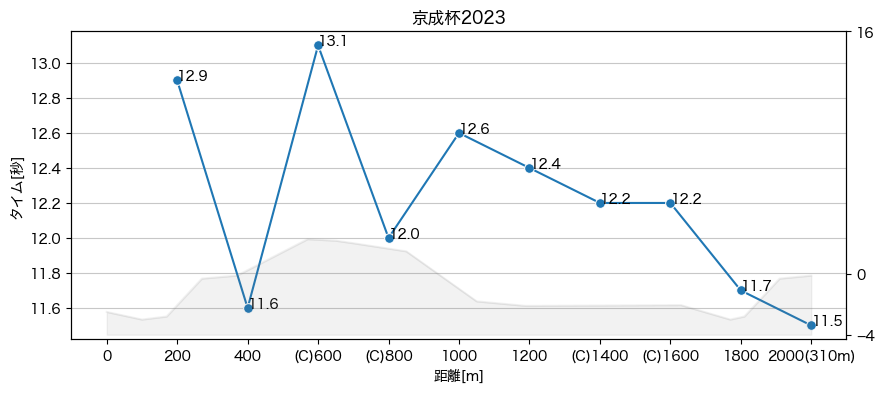

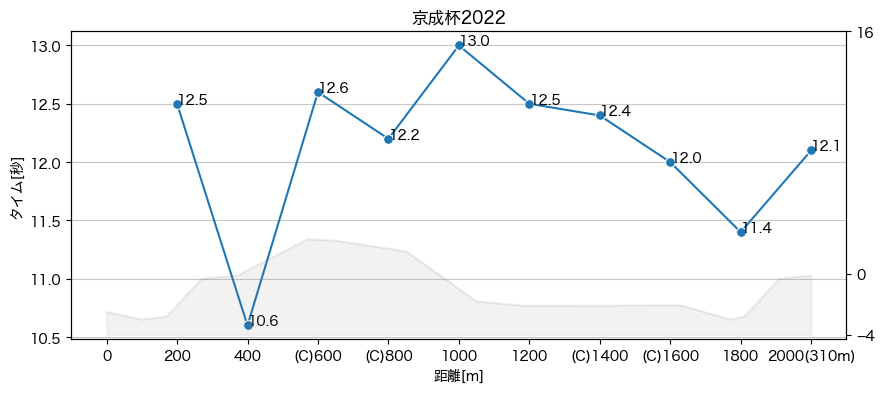

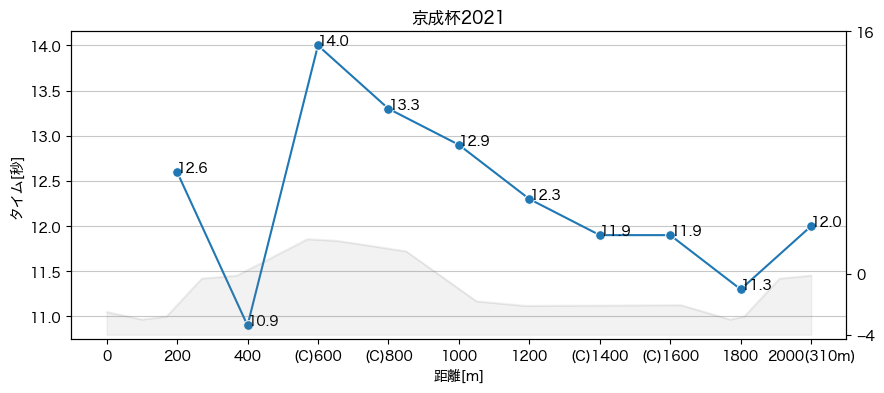

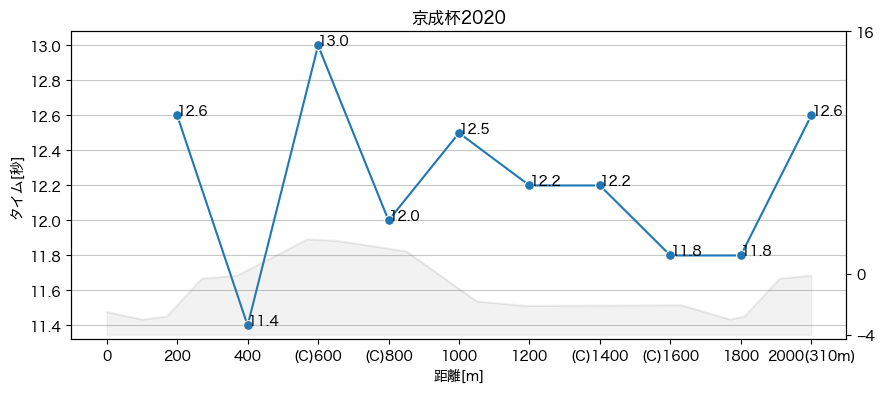

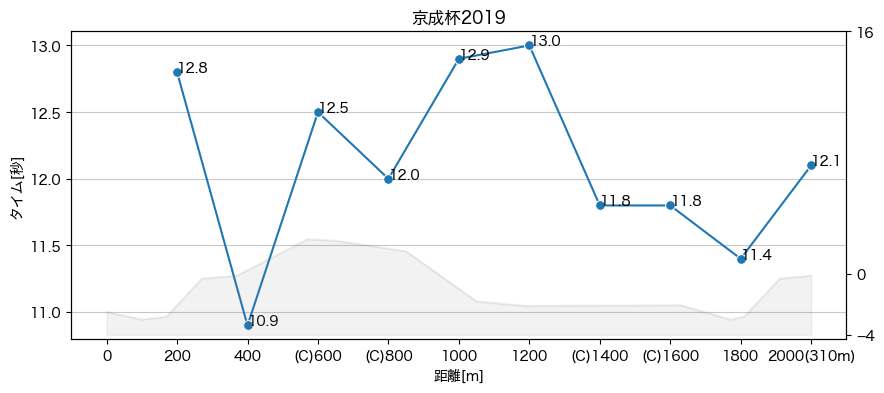

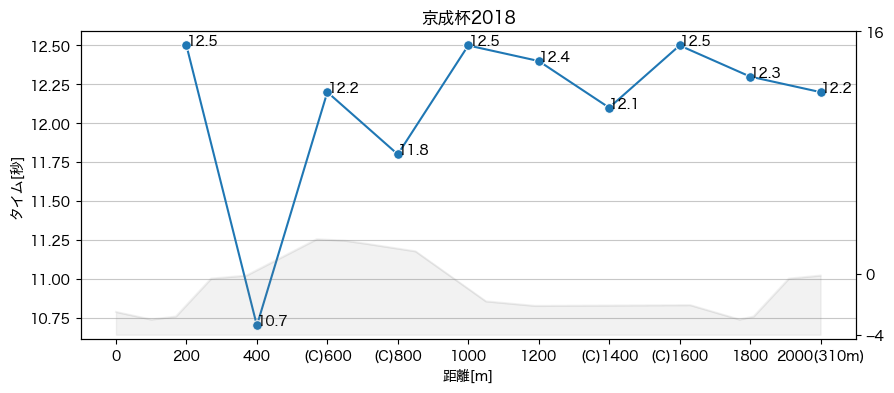

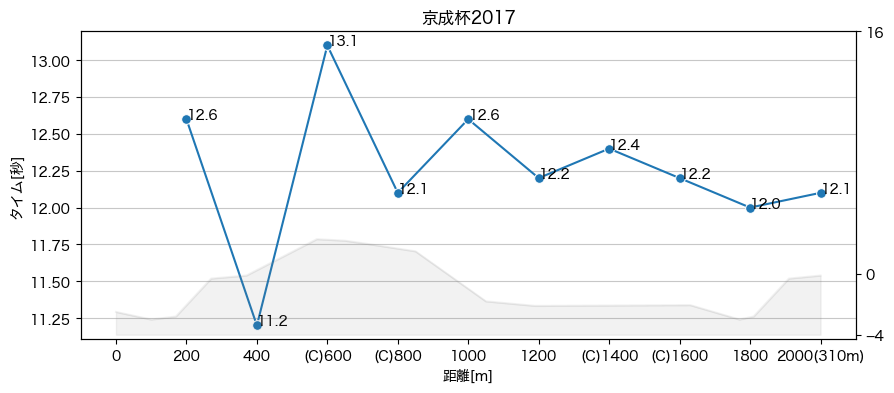

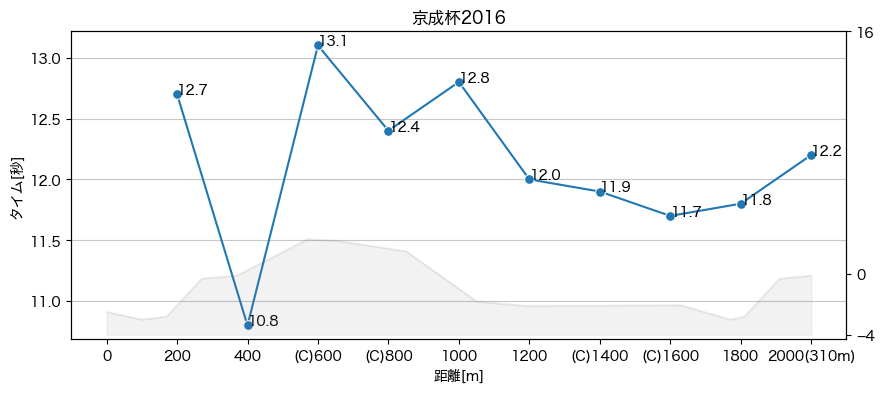

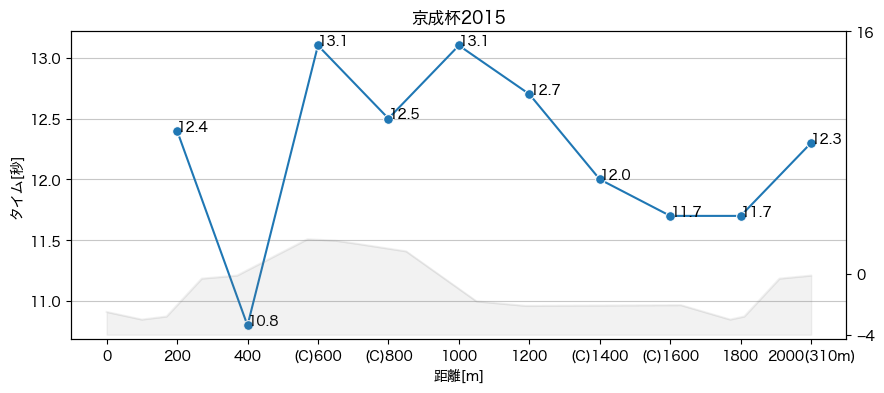

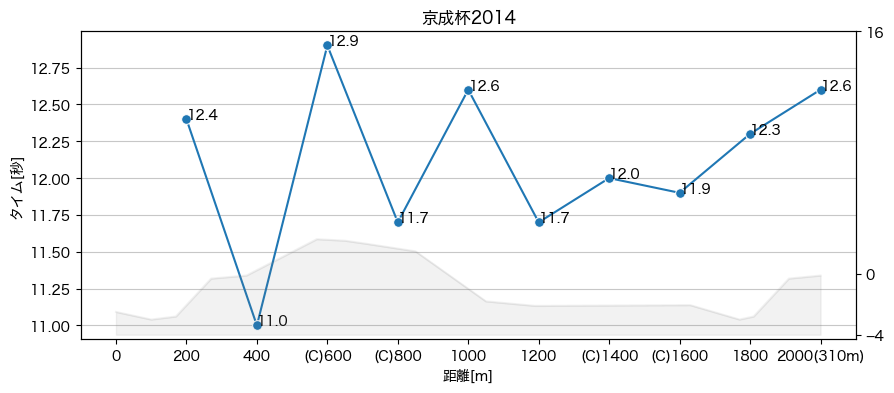

In [35]:
for lap, year in zip(df.lap.unique().tolist(), df.year.unique().tolist()):
    mc.lap_plot(lap, "京成杯{}".format(year))

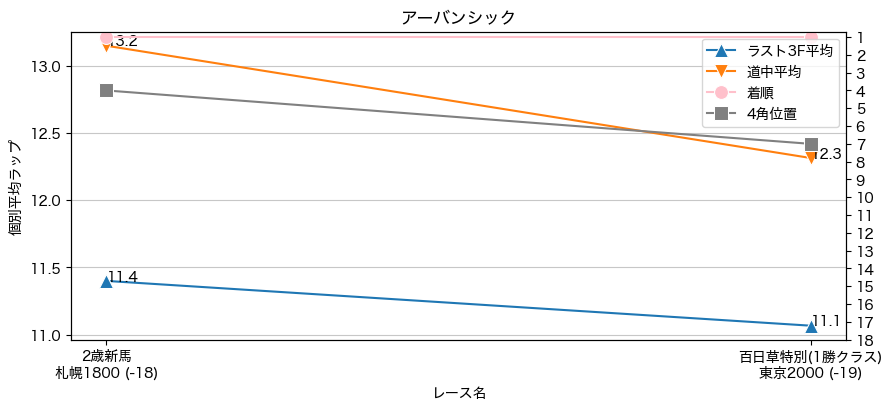

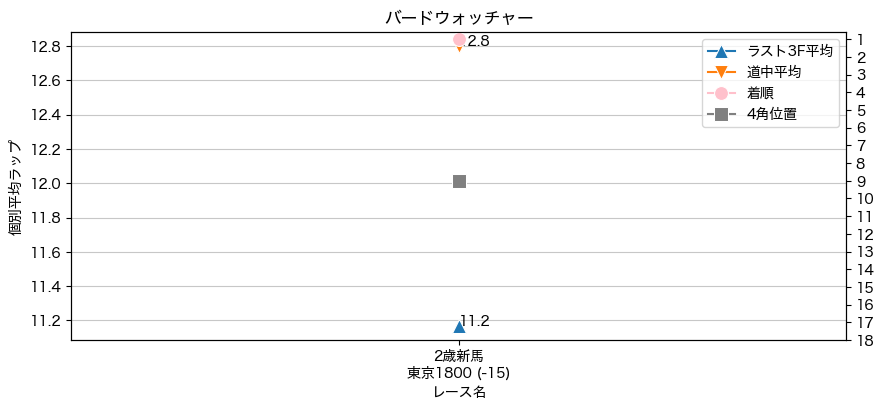

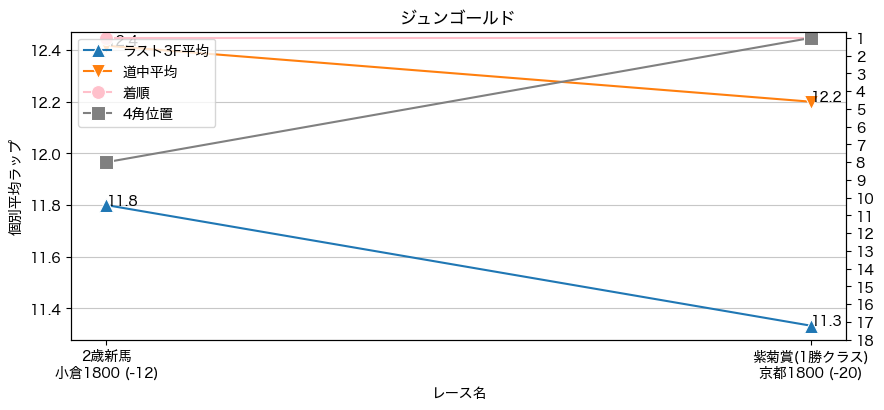

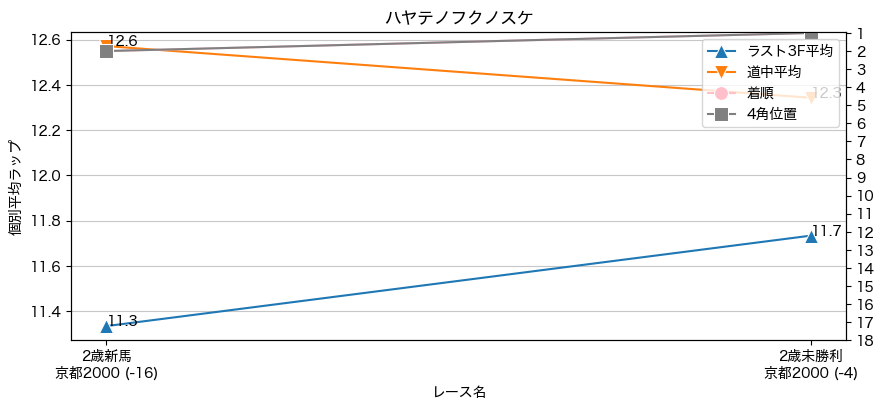

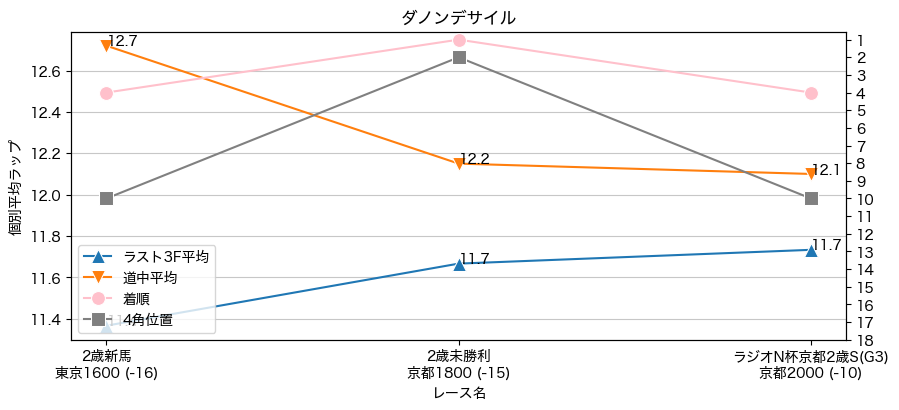

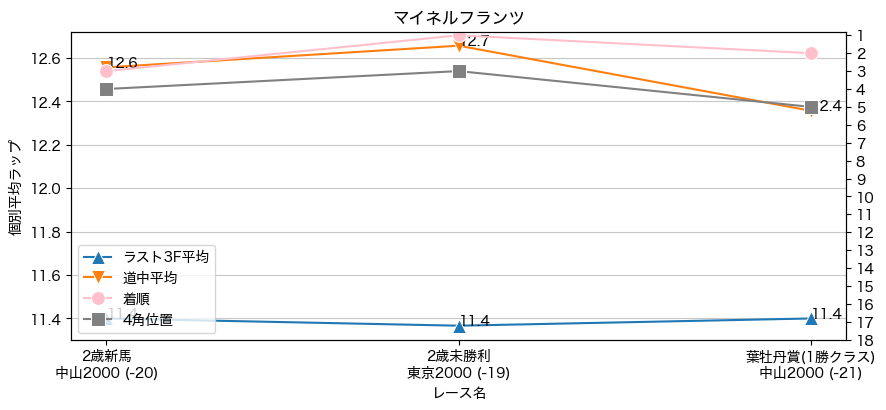

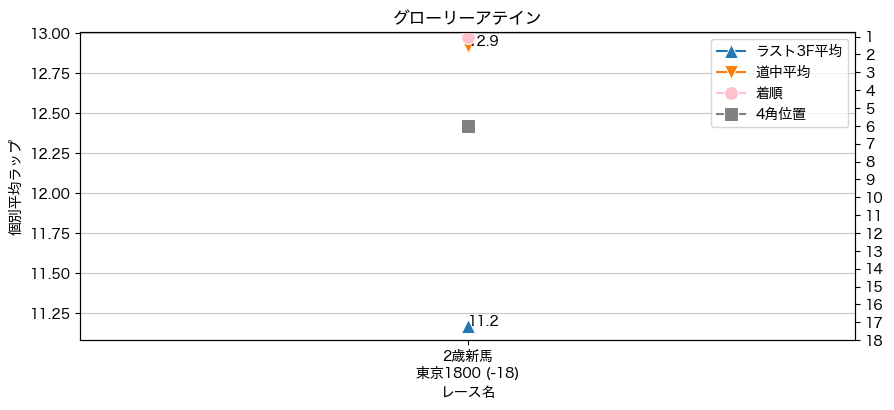

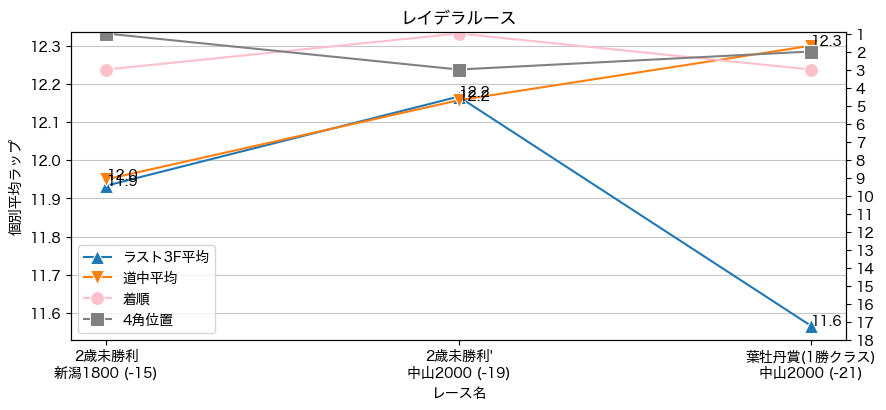

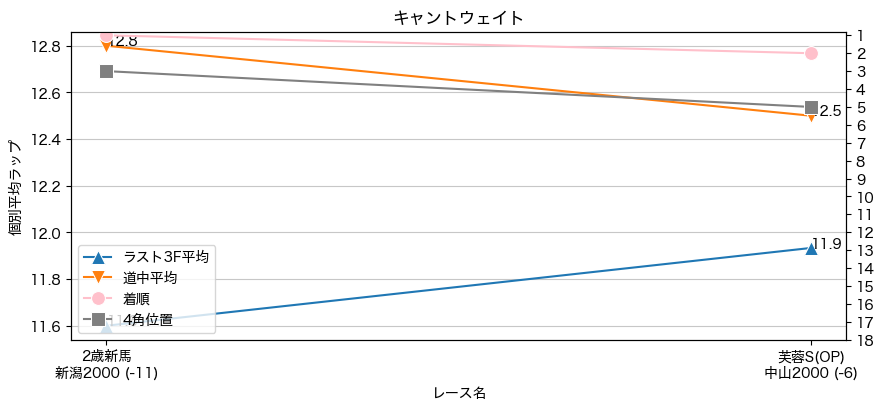

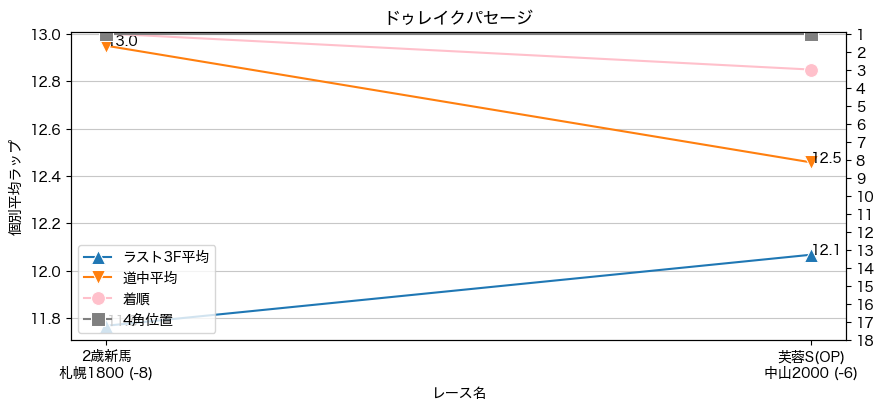

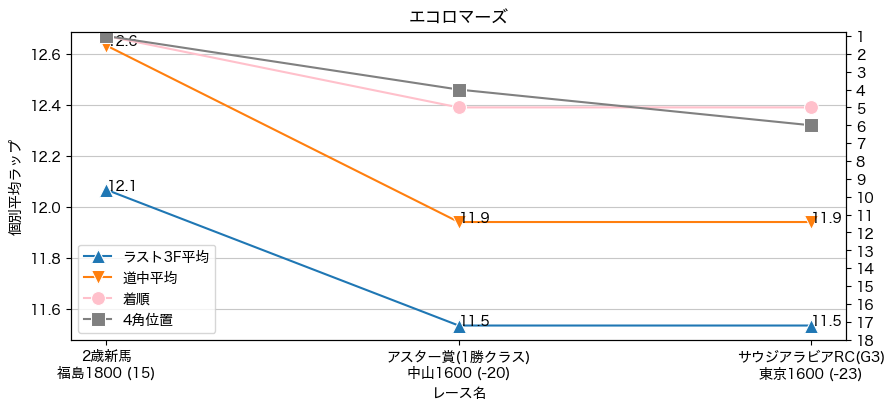

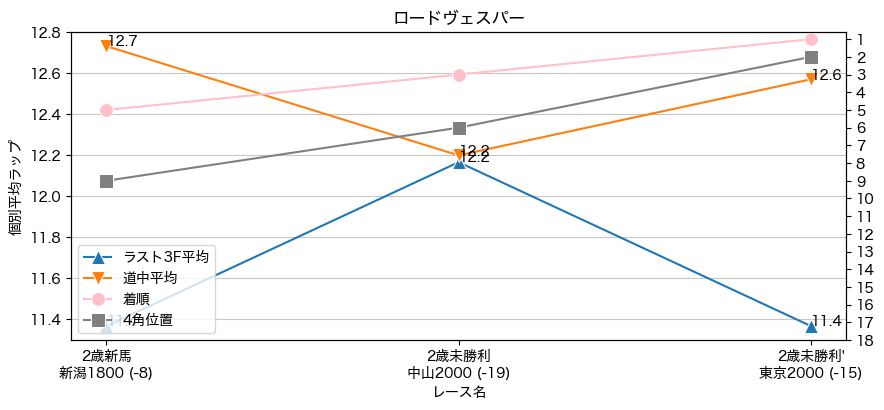

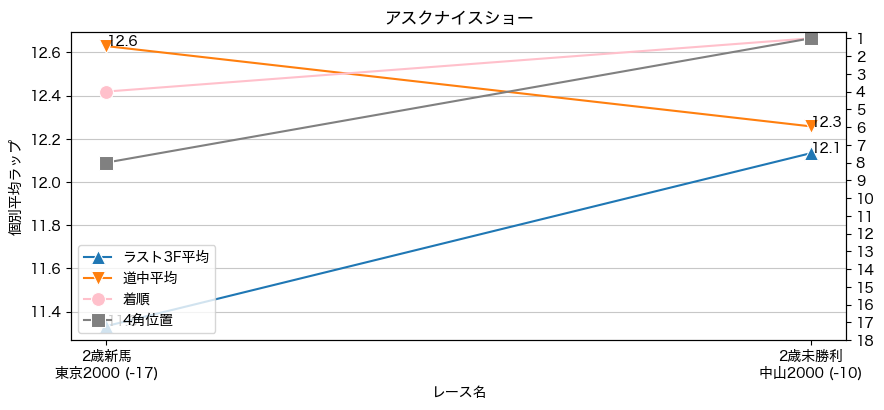

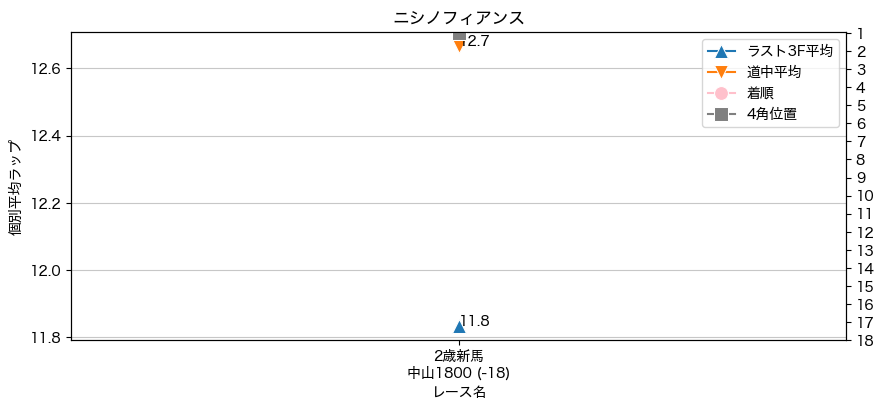

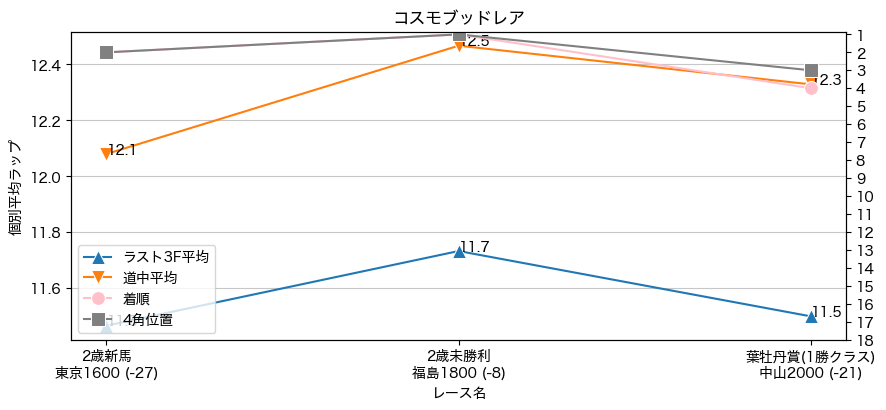

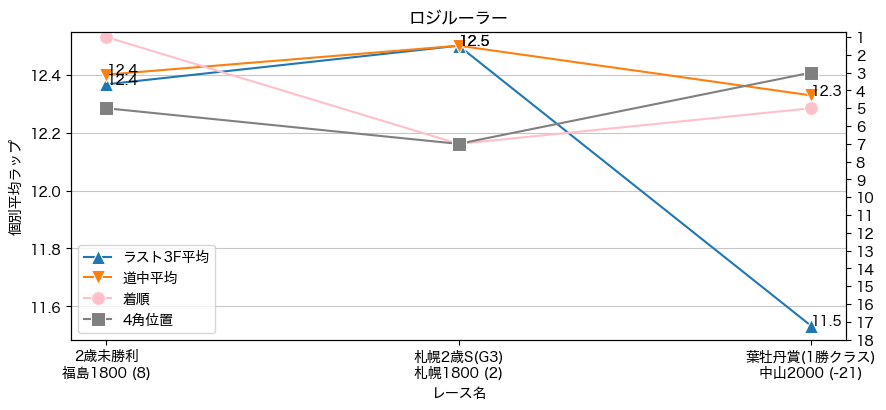

In [8]:
mc.lap_plot_horse(pdf.sort_values("popular"), past=False)

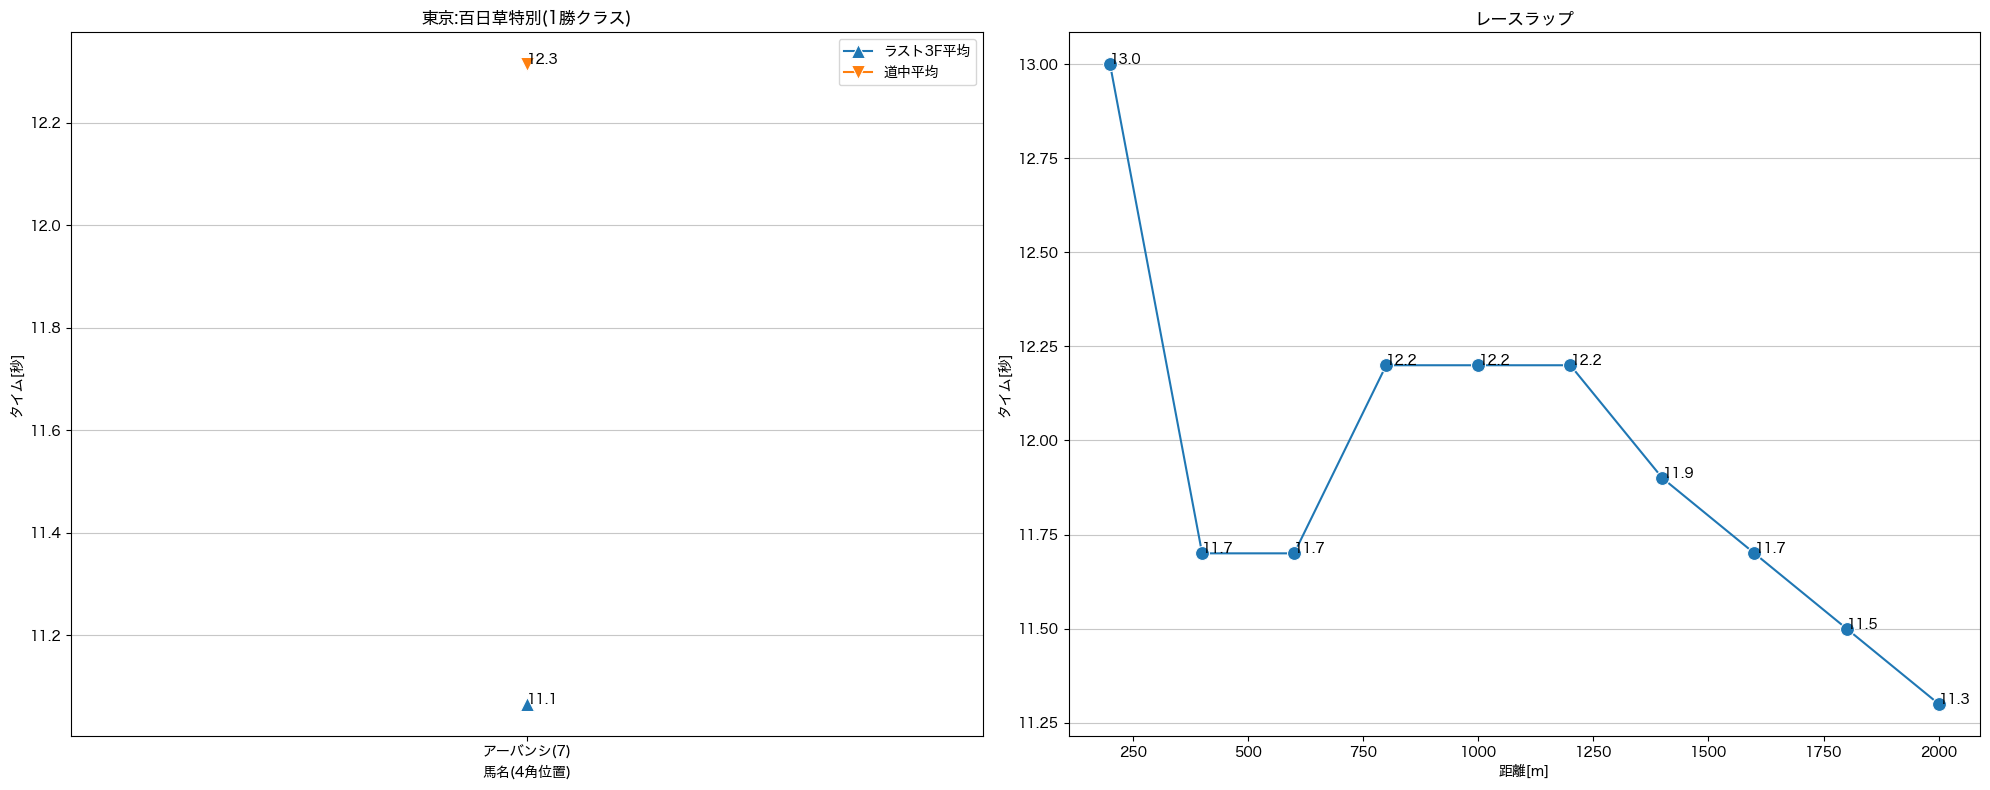

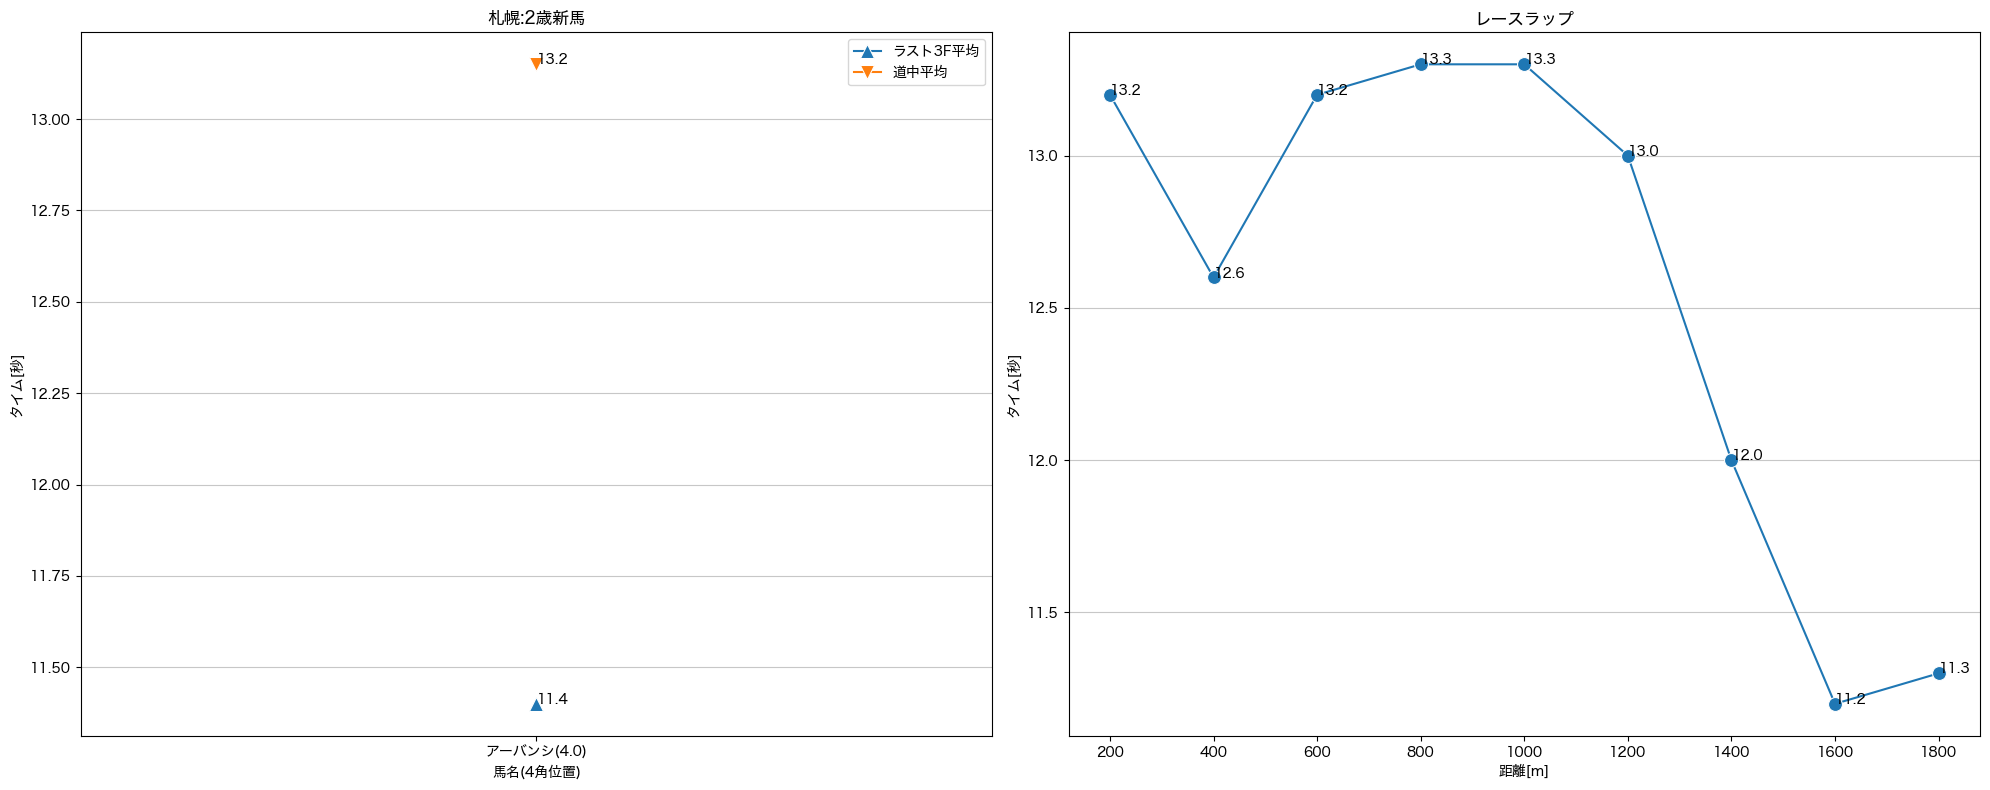

In [11]:
for i in range(2):
    mc.pre_lap_plot(pdf[pdf.horse_name=="アーバンシック"], pre_num=i+1)

In [22]:
mc.make_col_df(df, "waku")

,頭数,1着,2着,3着,着外,勝率,複勝率,オッズ平均,1着オッズ平均,馬券内オッズ平均
waku,,,,,,,,,,
1,13,1,1,2,9,7.69%,30.77%,31.107692,20.9,11.500000
2,16,0,1,2,13,0.00%,18.75%,49.037500,NaN,14.700000
3,16,2,2,1,11,12.50%,31.25%,90.450000,7.2,29.120000
4,16,1,1,1,13,6.25%,18.75%,34.462500,2.7,14.266667
5,19,2,1,1,15,10.53%,21.05%,50.226316,8.5,8.325000
6,19,2,1,2,14,10.53%,26.32%,35.552632,6.2,9.420000
7,19,0,0,1,18,0.00%,5.26%,53.810526,NaN,2.700000
8,21,2,3,0,16,9.52%,23.81%,33.933333,4.4,5.300000


In [26]:
mc.make_col_df(df, "pre1_dist")

,頭数,1着,2着,3着,着外,勝率,複勝率,オッズ平均,1着オッズ平均,馬券内オッズ平均
pre1_dist,,,,,,,,,,
1400,1,0,0,0,1,0.00%,0.00%,344.600000,NaN,NaN
1600,19,1,1,0,17,5.26%,10.53%,72.926316,7.30,62.650000
1800,35,4,1,1,29,11.43%,17.14%,47.974286,10.00,11.800000
2000,84,5,8,9,62,5.95%,26.19%,37.417857,5.78,8.727273


In [27]:
mc.make_col_df(df, "pre1_place")

,頭数,1着,2着,3着,着外,勝率,複勝率,オッズ平均,1着オッズ平均,馬券内オッズ平均
pre1_place,,,,,,,,,,
中京,1,0,0,0,1,0.00%,0.00%,115.500000,NaN,NaN
中山,61,5,6,5,45,8.20%,26.23%,56.395082,9.740000,14.531250
京都,9,1,2,0,6,11.11%,33.33%,37.611111,11.300000,13.233333
小倉,1,0,0,1,0,0.00%,100.00%,12.600000,NaN,12.600000
新潟,3,0,0,0,3,0.00%,0.00%,11.566667,NaN,NaN
札幌,1,0,0,0,1,0.00%,0.00%,164.600000,NaN,NaN
東京,31,3,2,0,26,9.68%,16.13%,39.864516,3.633333,3.360000
福島,3,0,0,0,3,0.00%,0.00%,31.700000,NaN,NaN
阪神,28,1,0,4,23,3.57%,17.86%,27.935714,5.300000,17.300000


In [29]:
mc.make_col_df(df, "pre1_race_rank")

,頭数,1着,2着,3着,着外,勝率,複勝率,オッズ平均,1着オッズ平均,馬券内オッズ平均
pre1_race_rank,,,,,,,,,,
1勝,38,3,2,3,30,7.89%,21.05%,56.234211,4.20,5.925000
G1,10,2,0,1,7,20.00%,30.00%,33.140000,10.25,7.733333
G2,15,0,1,1,13,0.00%,13.33%,45.360000,NaN,5.700000
G3,17,0,1,0,16,0.00%,5.88%,43.082353,NaN,14.000000
L,2,0,1,0,1,0.00%,50.00%,228.300000,NaN,118.000000
OP,8,1,0,0,7,12.50%,12.50%,35.900000,11.30,11.300000
新馬,19,4,1,3,11,21.05%,42.11%,25.068421,7.95,10.150000
未勝利,30,0,4,2,24,0.00%,20.00%,48.373333,NaN,13.600000
